In [74]:
import numpy as np
import random
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from scipy.optimize import minimize, fsolve
from scipy.special import gamma, erf
from scipy.stats import pearsonr, poisson
from sklearn.metrics import r2_score
from statannotations.Annotator import Annotator     #https://github.com/trevismd/statannotations
from MLE_functions import *

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "figure.figsize": (10, 10),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)


def relative_cis(kd_list, low_list, high_list):
    low = [round(k - l, 2) for k, l in zip(kd_list, low_list)]
    high = [round(h - k, 2) for k, h in zip(kd_list, high_list)]
    return low, high

def MAE(x, y):
    """Calculates mean square error of arrays x and y"""
    ae = [abs(x - y) for x, y in zip(x, y)]
    mae = np.mean(ae)
    return round(mae, 3)

In [2]:
# sensitivity analysis sigma
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.figsize": (10, 5),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)

input_csv = ("/projects/brpe7306/fab-library-barcoding/Match_final/_collapsed.csv")

input_df = pd.read_csv(input_csv)
#bcs = input_df["Variant"].unique()[:10]
#input_df = input_df[input_df["Variant"].isin(bcs)]

kd_guesses = [50, 70, 100]
fmax_guesses = [40000, 30000, 20000]
conc_to_ignore = [0, 1, 25]

test_1 = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    ext_error=0.02,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("1 failures:", len(test_1[test_1["Success"] == False]))

test_2 = run_mle(
    input_df,
    conc_to_ignore,
    sigma=0.9,
    B=350,
    ext_error=0.02,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("2 failures:", len(test_2[test_2["Success"] == False]))

test_3 = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.1,
    B=350,
    ext_error=0.02,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("3 failures:", len(test_3[test_3["Success"] == False]))

input_csv = ("/projects/brpe7306/fab-library-barcoding/Match_final_concat/_collapsed.csv")
input_df = pd.read_csv(input_csv)
#input_df = input_df[input_df["Variant"].isin(bcs)]

test_4 = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    ext_error=0.02,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("4 failures:", len(test_4[test_4["Success"] == False]))

test_5 = run_mle(
    input_df,
    conc_to_ignore,
    sigma=0.9,
    B=350,
    ext_error=0.02,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("5 failures:", len(test_5[test_5["Success"] == False]))

test_6 = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.1,
    B=350,
    ext_error=0.02,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("6 failures:", len(test_6[test_6["Success"] == False]))

s = test_1["Success"] & test_2["Success"] & test_3["Success"] & test_4["Success"] & test_5["Success"] & test_6["Success"]
test_1 = test_1[s]
test_2 = test_2[s]
test_3 = test_3[s]
test_4 = test_4[s]
test_5 = test_5[s]
test_6 = test_6[s]

In [130]:
kd_cutoff = 1000
fmax_cutoff = 12000
variant_or_barcode = 'Variant'
i = 1
all_dfs = []

for test_top25, test_top50 in [(test_1, test_4), (test_2, test_5), (test_3, test_6)]:
    combined = pd.DataFrame()
    for variant in test_top25[variant_or_barcode]:
        try:
            kd = test_top25[test_top25[variant_or_barcode] == variant]['Kd'].values[0]
            fmax = test_top25[test_top25[variant_or_barcode] == variant]['Fmax'].values[0]
            ll_top25 = test_top25[test_top25[variant_or_barcode] == variant]['LL'].values[0]
            if kd > kd_cutoff or fmax < fmax_cutoff:
                new_kd = test_top50[test_top50[variant_or_barcode] == variant]['Kd'].values[0]
                new_fmax = test_top50[test_top50[variant_or_barcode] == variant]['Fmax'].values[0]
                ll_top50 = test_top50[test_top50[variant_or_barcode] == variant]['LL'].values[0]
                combined = combined.append(test_top50[test_top50[variant_or_barcode] == variant], ignore_index=True)
                print(variant, ": ", kd, fmax, " --> ", new_kd, new_fmax, ll_top25, ll_top50)
            else:
                combined = combined.append(test_top25[test_top25[variant_or_barcode] == variant], ignore_index=True)
        except:
            combined = combined.append(test_top25[test_top25[variant_or_barcode] == variant], ignore_index=True)
            print("cant find", variant)
    all_dfs.append(combined)
    #combined.to_csv("sigma"+str(i)+".csv", index=False)
    i += 1

4A8>VH:A9A-GCC;V20V-GTG;T98T-ACA;Q120K-AAA|4A8>VL:S7T-ACT;A85A-GCT;E86E-GAA;T94M-ATG;P100P-CCT;V109L-CTG;D110E-GAG :  113.96 9641.69  -->  153.84 9628.52 5.34 24.56
4A8>VH:G49G-GGG;Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG;V109L-CTG :  6482.12 38093.55  -->  202.96 7901.65 5.28 21.29
4A8>VH:M59I-ATC;Q120K-AAA|4A8>VL:T5T-ACA;T94M-ATG :  6358.94 38239.96  -->  543.62 5622.34 11.73 28.93
4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT :  77.08 11395.93  -->  134.44 9475.81 10.89 40.98
4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG :  6540.3 38119.63  -->  226.89 9469.43 5.27 50.12
4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG;D110E-GAG :  361.57 11706.98  -->  248.54 9380.86 3.15 41.29
4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG;V109L-CTG;D110E-GAG :  157.5 8286.42  -->  163.76 9317.17 6.41 30.66
4A8>VH:Q120K-AAA|4A8>VL:T94M-ATG :  313.13 11082.2  -->  230.38 10181.35 3.11 51.41
4A8>VH:Q120K-AAA|4A8>VL:T94M-ATG;D110E-GAG :  7553.05 37467.73  -->  565.69 6062.9 5.94 11.88
4A8>VH:Q120K-AAA|4A8>VL:T94M-ATG;V109L-CTG :  1886.43 1

4A8>VH:M59I-ATC|4A8>VL:T94M-ATG;D110E-GAG 0.5970000000000004
4A8>VH:M59I-ATC|4A8>VL:T94M-ATG;V109L-CTG 0.8449999999999998
4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT 0.42300000000000004
4A8>VH:Q120K-AAA|4A8>VL:WT 0.31099999999999994
4A8>VH:M59I-ATC;Q120K-AAA|4A8>VL:S7T-ACT;V109L-CTG 0.6340000000000003
4A8>VH:M59I-ATC|4A8>VL:T94M-ATG;V109L-CTG 0.8529999999999998
[[0.02, 0.72, 0.02, 0.01], [0.04, 0.04, 0.04, 0.05]]
[[0.34, 0.72], [0.37, 0.04]]


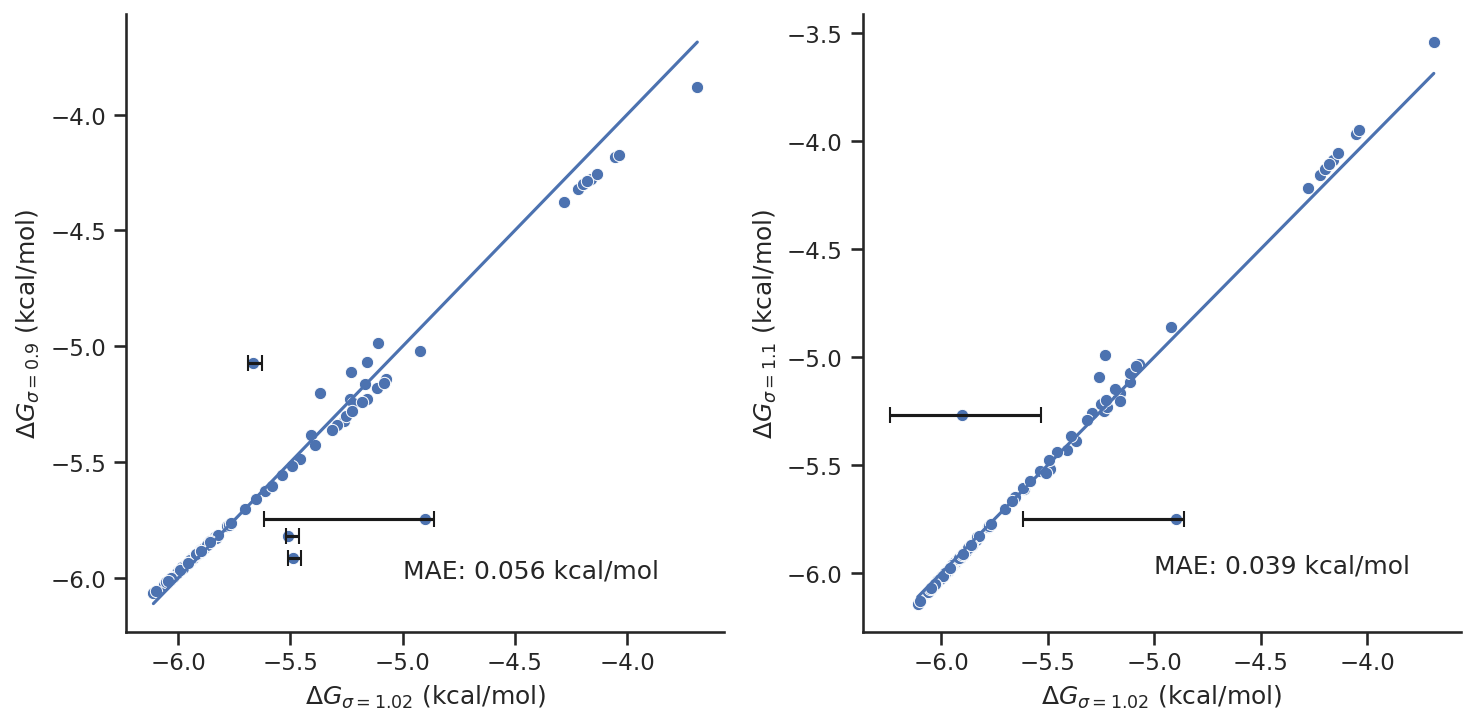

In [131]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.figsize": (10, 5),
}
sns.set(rc=custom_params, style="ticks", font_scale=1)

filtered_dfs = []
for df in all_dfs:
    df = df[df["95% CI low"] != df["95% CI high"]]
    df = df[df["95% CI low"] != 0]
    df = df[df["95% CI high"] != 0]
    df = df[df["95% CI high"] < 30000]
    df = df[(df["95% CI low"] < df["Kd"]) & (df["Kd"] < df["95% CI high"])]
    df = df[df["Avg_counts"] > 30]
    filtered_dfs.append(df)

filtered_dfs[0] = filtered_dfs[0][(filtered_dfs[0]['Variant'].isin(filtered_dfs[1]['Variant'])) & (filtered_dfs[0]['Variant'].isin(filtered_dfs[2]['Variant']))]
filtered_dfs[1] = filtered_dfs[1][(filtered_dfs[1]['Variant'].isin(filtered_dfs[2]['Variant'])) & (filtered_dfs[1]['Variant'].isin(filtered_dfs[0]['Variant']))]
filtered_dfs[2] = filtered_dfs[2][(filtered_dfs[2]['Variant'].isin(filtered_dfs[0]['Variant'])) & (filtered_dfs[2]['Variant'].isin(filtered_dfs[1]['Variant']))]

filtered_dfs[0].to_csv("sigma1_02.csv", index=False)
filtered_dfs[1].to_csv("sigma0_9.csv", index=False)
filtered_dfs[2].to_csv("sigma1_1.csv", index=False)

outliers1, outliers2 = [], []

for variant in filtered_dfs[0]['Variant']:
    abs_diff = abs(filtered_dfs[0][filtered_dfs[0]['Variant'] == variant]['dg'].values[0] - filtered_dfs[1][filtered_dfs[1]['Variant'] == variant]['dg'].values[0])
    if abs_diff > 0.3:
        print(variant, abs_diff)
        outliers1.append(variant)

for variant in filtered_dfs[0]['Variant']:
    abs_diff = abs(filtered_dfs[0][filtered_dfs[0]['Variant'] == variant]['dg'].values[0] - filtered_dfs[2][filtered_dfs[2]['Variant'] == variant]['dg'].values[0])
    if abs_diff > 0.3:
        print(variant, abs_diff)
        outliers2.append(variant)

plt.subplot(121)
sns.scatterplot(
    x=filtered_dfs[0]["dg"],
    y=filtered_dfs[1]["dg"],
    s=35,
)
plt.text(
    -5,
    -6,
    "MAE: "
    + str(MAE(filtered_dfs[0]["dg"], filtered_dfs[1]["dg"]))
    + " kcal/mol",
)

plt.plot(
    [min(filtered_dfs[0]["dg"]), max(filtered_dfs[0]["dg"])],
    [min(filtered_dfs[0]["dg"]), max(filtered_dfs[0]["dg"])],
)
dg_low = [kd_to_ddg(val, 1_000_000) for val in filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers1)]["95% CI low"].to_list()]
dg_high = [kd_to_ddg(val, 1_000_000) for val in filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers1)]["95% CI high"].to_list()]
low, high = relative_cis(filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers1)]["dg"].to_list(), dg_low, dg_high)
error = [low, high]
print(error)
plt.errorbar(x=filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers1)]["dg"], y=filtered_dfs[1][filtered_dfs[1]['Variant'].isin(outliers1)]["dg"], xerr=error, fmt="none", capsize=4, ecolor="k", zorder=1)

plt.xlabel(r"$\Delta G_{\sigma = 1.02}$ (kcal/mol)")
plt.ylabel(r"$\Delta G_{\sigma = 0.9}$ (kcal/mol)")
plt.legend('',frameon=False)

plt.subplot(122)
sns.scatterplot(
    x=filtered_dfs[0]["dg"],
    y=filtered_dfs[2]["dg"],
    s=35,
)
plt.text(
    -5,
    -6,
    "MAE: "
    + str(MAE(filtered_dfs[0]["dg"], filtered_dfs[2]["dg"]))
    + " kcal/mol",
)
plt.plot(
    [min(filtered_dfs[0]["dg"]), max(filtered_dfs[0]["dg"])],
    [min(filtered_dfs[0]["dg"]), max(filtered_dfs[0]["dg"])],
)
dg_low = [kd_to_ddg(val, 1_000_000) for val in filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers2)]["95% CI low"].to_list()]
dg_high = [kd_to_ddg(val, 1_000_000) for val in filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers2)]["95% CI high"].to_list()]
low, high = relative_cis(filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers2)]["dg"].to_list(), dg_low, dg_high)
error = [low, high]
print(error)
plt.errorbar(x=filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers2)]["dg"], y=filtered_dfs[2][filtered_dfs[2]['Variant'].isin(outliers2)]["dg"], xerr=error, fmt="none", capsize=4, ecolor="k", zorder=1)
plt.xlabel(r"$\Delta G_{\sigma = 1.02}$ (kcal/mol)")
plt.ylabel(r"$\Delta G_{\sigma = 1.1}$ (kcal/mol)")
plt.legend('', frameon=False)
plt.tight_layout()
plt.savefig("sigma1.png")
plt.show()

In [43]:
# sensitivity analysis extrinsic error 
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.figsize": (10, 5),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)

input_csv = ("/projects/brpe7306/fab-library-barcoding/Match_final/_collapsed.csv")

input_df = pd.read_csv(input_csv)
#bcs = input_df["Variant"].unique()[:10]
#input_df = input_df[input_df["Variant"].isin(bcs)]

kd_guesses = [50, 70, 100]
fmax_guesses = [40000, 30000, 20000]
conc_to_ignore = [0, 1, 25]

test_1e = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    ext_error=0.02,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("1 failures:", len(test_1e[test_1e["Success"] == False]))

test_2e = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    ext_error=0.01,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("2 failures:", len(test_2e[test_2e["Success"] == False]))

test_3e = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    ext_error=0.03,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("3 failures:", len(test_3e[test_3e["Success"] == False]))

input_csv = ("/projects/brpe7306/fab-library-barcoding/Match_final_concat/_collapsed.csv")
input_df = pd.read_csv(input_csv)
#input_df = input_df[input_df["Variant"].isin(bcs)]

test_4e = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    ext_error=0.02,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("4 failures:", len(test_4e[test_4e["Success"] == False]))

test_5e = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    ext_error=0.01,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("5 failures:", len(test_5e[test_5e["Success"] == False]))

test_6e = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    ext_error=0.03,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Variant",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
print("6 failures:", len(test_6e[test_6e["Success"] == False]))

s = test_1e["Success"] & test_2e["Success"] & test_3e["Success"] & test_4e["Success"] & test_5e["Success"] & test_6e["Success"]
test_1e = test_1e[s]
test_2e = test_2e[s]
test_3e = test_3e[s]
test_4e = test_4e[s]
test_5e = test_5e[s]
test_6e = test_6e[s]

1 failures: 0███████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
2 failures: 3███████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
3 failures: 0███████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
4 failures: 2███████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
5 failures: 3███████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
6 failures: 2███████████████████████████████████████████████████████████████████████████████████████ 100.0% complete


In [132]:
kd_cutoff = 1000
fmax_cutoff = 12000
variant_or_barcode = 'Variant'
i = 1
all_dfs = []

for test_top25, test_top50 in [(test_1e, test_4e), (test_2e, test_5e), (test_3e, test_6e)]:
    combined = pd.DataFrame()
    for variant in test_top25[variant_or_barcode]:
        try:
            kd = test_top25[test_top25[variant_or_barcode] == variant]['Kd'].values[0]
            fmax = test_top25[test_top25[variant_or_barcode] == variant]['Fmax'].values[0]
            ll_top25 = test_top25[test_top25[variant_or_barcode] == variant]['LL'].values[0]
            if kd > kd_cutoff or fmax < fmax_cutoff:
                new_kd = test_top50[test_top50[variant_or_barcode] == variant]['Kd'].values[0]
                new_fmax = test_top50[test_top50[variant_or_barcode] == variant]['Fmax'].values[0]
                ll_top50 = test_top50[test_top50[variant_or_barcode] == variant]['LL'].values[0]
                combined = combined.append(test_top50[test_top50[variant_or_barcode] == variant], ignore_index=True)
                print(variant, ": ", kd, fmax, " --> ", new_kd, new_fmax, ll_top25, ll_top50)
            else:
                combined = combined.append(test_top25[test_top25[variant_or_barcode] == variant], ignore_index=True)
        except:
            combined = combined.append(test_top25[test_top25[variant_or_barcode] == variant], ignore_index=True)
            print("cant find", variant)
    all_dfs.append(combined)
    #combined.to_csv("error"+str(i)+".csv", index=False)
    i += 1

4A8>VH:A9A-GCC;V20V-GTG;T98T-ACA;Q120K-AAA|4A8>VL:S7T-ACT;A85A-GCT;E86E-GAA;T94M-ATG;P100P-CCT;V109L-CTG;D110E-GAG :  113.96 9641.69  -->  153.84 9628.52 5.34 24.56
4A8>VH:G49G-GGG;Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG;V109L-CTG :  6482.12 38093.55  -->  202.96 7901.65 5.28 21.29
4A8>VH:M59I-ATC;Q120K-AAA|4A8>VL:T5T-ACA;T94M-ATG :  6358.94 38239.96  -->  543.62 5622.34 11.73 28.93
4A8>VH:M59I-ATC|4A8>VL:T94M-ATG;Q105*-TAG;V109L-CTG :  6958.81 37993.52  -->  15363.91 31328.09 4.75 13.05
4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT :  77.08 11395.93  -->  134.44 9475.81 10.89 40.98
4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG :  6540.3 38119.63  -->  226.89 9469.43 5.27 50.12
4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG;D110E-GAG :  361.57 11706.98  -->  248.54 9380.86 3.15 41.29
4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG;V109L-CTG;D110E-GAG :  157.5 8286.42  -->  163.76 9317.17 6.41 30.66
4A8>VH:Q120K-AAA|4A8>VL:T94M-ATG :  313.13 11082.2  -->  230.38 10181.35 3.11 51.41
4A8>VH:Q120K-AAA|4A8>VL:T94M-ATG;D110E-GAG

4A8>VH:M59I-ATC;Q120K-AAA|4A8>VL:S7T-ACT;V109L-CTG;D110E-GAG 0.4820000000000002
4A8>VH:M59I-ATC|4A8>VL:S7T-ACT;T94M-ATG 0.6139999999999999
4A8>VH:M59I-ATC|4A8>VL:T94M-ATG;V109L-CTG 0.8369999999999997
CC121>VH:L27F-TTC|CC121>VL:V3Q-CAG 0.742
4A8>VH:M59I-ATC;Q120K-AAA|4A8>VL:WT 0.8200000000000003
4A8>VH:M59I-ATC|4A8>VL:T94M-ATG;V109L-CTG 0.8549999999999995
[[0.5, 0.03, 0.71, 0.01], [0.27, 0.03, 0.04, 0.04]]
[[0.26, 0.71], [0.26, 0.04]]


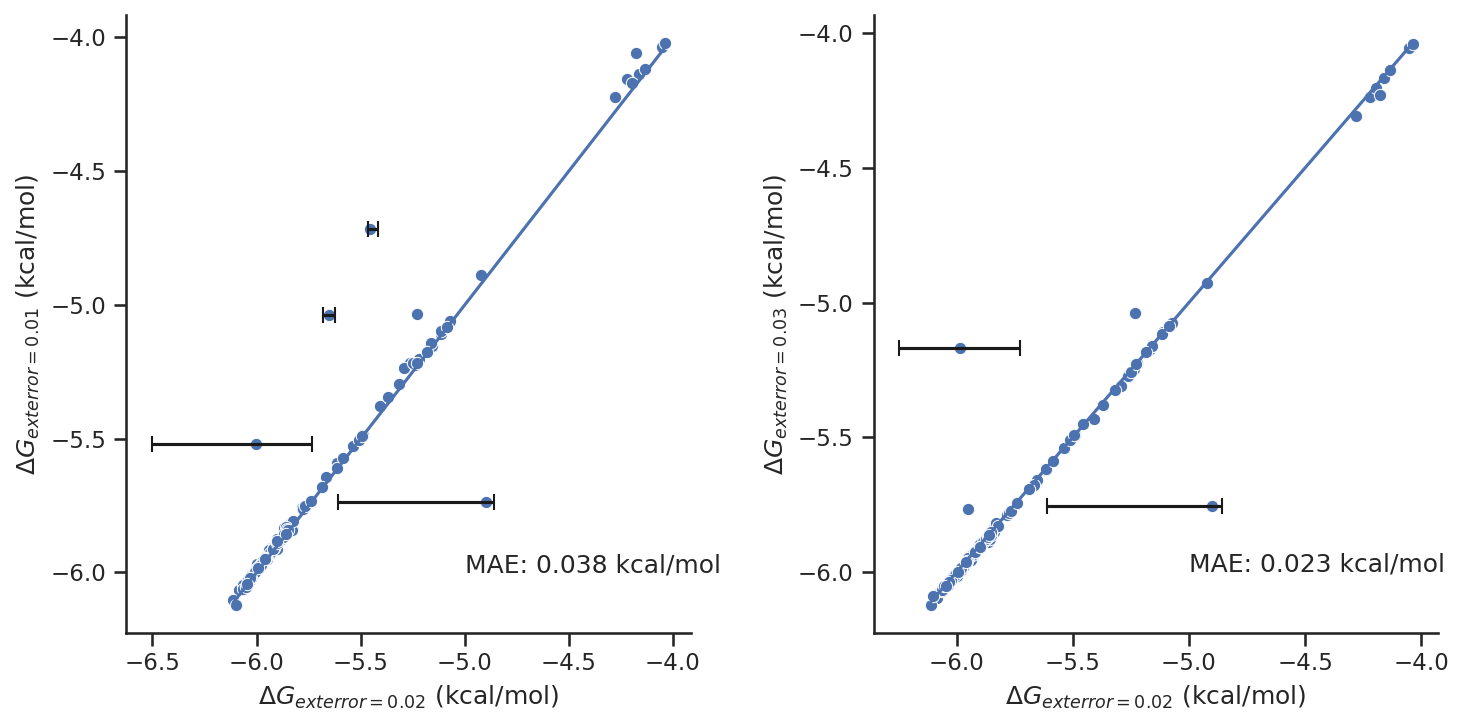

In [133]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.figsize": (10, 5),
}
sns.set(rc=custom_params, style="ticks", font_scale=1)

filtered_dfs = []
for df in all_dfs:
    df = df[df["95% CI low"] != df["95% CI high"]]
    df = df[df["95% CI low"] != 0]
    df = df[df["95% CI high"] != 0]
    df = df[df["95% CI high"] < 30000]
    df = df[(df["95% CI low"] < df["Kd"]) & (df["Kd"] < df["95% CI high"])]
    df = df[df["Avg_counts"] > 30]
    filtered_dfs.append(df)

filtered_dfs[0] = filtered_dfs[0][(filtered_dfs[0]['Variant'].isin(filtered_dfs[1]['Variant'])) & (filtered_dfs[0]['Variant'].isin(filtered_dfs[2]['Variant']))]
filtered_dfs[1] = filtered_dfs[1][(filtered_dfs[1]['Variant'].isin(filtered_dfs[2]['Variant'])) & (filtered_dfs[1]['Variant'].isin(filtered_dfs[0]['Variant']))]
filtered_dfs[2] = filtered_dfs[2][(filtered_dfs[2]['Variant'].isin(filtered_dfs[0]['Variant'])) & (filtered_dfs[2]['Variant'].isin(filtered_dfs[1]['Variant']))]

filtered_dfs[0].to_csv("error0_02.csv", index=False)
filtered_dfs[1].to_csv("error0_01.csv", index=False)
filtered_dfs[2].to_csv("error0_03.csv", index=False)

outliers1, outliers2 = [], []

for variant in filtered_dfs[0]['Variant']:
    abs_diff = abs(filtered_dfs[0][filtered_dfs[0]['Variant'] == variant]['dg'].values[0] - filtered_dfs[1][filtered_dfs[1]['Variant'] == variant]['dg'].values[0])
    if abs_diff > 0.3:
        print(variant, abs_diff)
        outliers1.append(variant)

for variant in filtered_dfs[0]['Variant']:
    abs_diff = abs(filtered_dfs[0][filtered_dfs[0]['Variant'] == variant]['dg'].values[0] - filtered_dfs[2][filtered_dfs[2]['Variant'] == variant]['dg'].values[0])
    if abs_diff > 0.3:
        print(variant, abs_diff)
        outliers2.append(variant)
        
plt.subplot(121)
sns.scatterplot(
    x=filtered_dfs[0]["dg"],
    y=filtered_dfs[1]["dg"],
    s=35,
)
plt.text(
    -5,
    -6,
    "MAE: "
    + str(MAE(filtered_dfs[0]["dg"], filtered_dfs[1]["dg"]))
    + " kcal/mol",
)

plt.plot(
    [min(filtered_dfs[0]["dg"]), max(filtered_dfs[0]["dg"])],
    [min(filtered_dfs[0]["dg"]), max(filtered_dfs[0]["dg"])],
)
dg_low = [kd_to_ddg(val, 1_000_000) for val in filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers1)]["95% CI low"].to_list()]
dg_high = [kd_to_ddg(val, 1_000_000) for val in filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers1)]["95% CI high"].to_list()]
low, high = relative_cis(filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers1)]["dg"].to_list(), dg_low, dg_high)
error = [low, high]
print(error)
plt.errorbar(x=filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers1)]["dg"], y=filtered_dfs[1][filtered_dfs[1]['Variant'].isin(outliers1)]["dg"], xerr=error, fmt="none", capsize=4, ecolor="k", zorder=1)

plt.xlabel(r"$\Delta G_{ext error = 0.02}$ (kcal/mol)")
plt.ylabel(r"$\Delta G_{ext error = 0.01}$ (kcal/mol)")
plt.legend('',frameon=False)

plt.subplot(122)
sns.scatterplot(
    x=filtered_dfs[0]["dg"],
    y=filtered_dfs[2]["dg"],
    s=35,
)
plt.text(
    -5,
    -6,
    "MAE: "
    + str(MAE(filtered_dfs[0]["dg"], filtered_dfs[2]["dg"]))
    + " kcal/mol",
)
plt.plot(
    [min(filtered_dfs[0]["dg"]), max(filtered_dfs[0]["dg"])],
    [min(filtered_dfs[0]["dg"]), max(filtered_dfs[0]["dg"])],
)
dg_low = [kd_to_ddg(val, 1_000_000) for val in filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers2)]["95% CI low"].to_list()]
dg_high = [kd_to_ddg(val, 1_000_000) for val in filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers2)]["95% CI high"].to_list()]
low, high = relative_cis(filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers2)]["dg"].to_list(), dg_low, dg_high)
error = [low, high]
print(error)
plt.errorbar(x=filtered_dfs[0][filtered_dfs[0]['Variant'].isin(outliers2)]["dg"], y=filtered_dfs[2][filtered_dfs[2]['Variant'].isin(outliers2)]["dg"], xerr=error, fmt="none", capsize=4, ecolor="k", zorder=1)
plt.xlabel(r"$\Delta G_{ext error = 0.02}$ (kcal/mol)")
plt.ylabel(r"$\Delta G_{ext error = 0.03}$ (kcal/mol)")
plt.legend([], frameon=False)
plt.tight_layout()
plt.savefig("exterror1.png")
plt.show()

213
████████████████████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
████████████████████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
████████████████████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
████████████████████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
████████████████████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
████████████████████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
████████████████████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
████████████████████████████████████████████████████████████████████████████████████████████████████ 100.0% complete
████████████████████████████████████████████████████████████

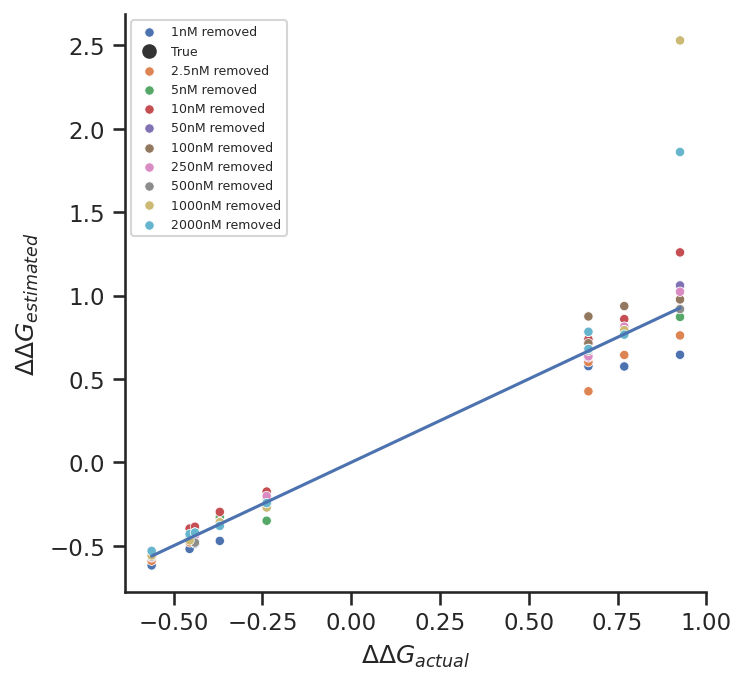

['1removed', '2.5removed', '5removed', '10removed', '50removed', '100removed', '250removed', '500removed', '1000removed', '2000removed']


In [13]:
# remove single concentration
input_csv = (
    "/projects/brpe7306/fab-library-barcoding/MLE/input/4A8_CC121_combined_ref.csv"
)
input_df = pd.read_csv(input_csv)
bcs = input_df["Barcode"].unique()[:10]
input_df = input_df[input_df["Barcode"].isin(bcs)]
print(len(input_df))
all_concs = [1, 2.5, 5, 10, 50, 100, 250, 500, 1000, 2000]
conc_to_ignore = [0, 25]
all_tests = []
test_all_concs = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Barcode",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)
sheets = []
for i in range(len(all_concs)):
    conc_to_ignore = [0, 25] + [all_concs[i]]
    sheets.append(str(all_concs[i]) + "removed")
    all_tests.append(
        run_mle(
            input_df,
            conc_to_ignore,
            sigma=1.02,
            B=350,
            kd_guesses=kd_guesses,
            fmax_guesses=fmax_guesses,
            variant_col="Barcode",
            top25_only=True,
            highmid_only=False,
            plot=False,
            print_df=False,
        )
    )

for i, df in enumerate(all_tests):
    s = test_all_concs["Success"] & df["Success"]
    sns.scatterplot(
        x=test_all_concs["ddg"],
        y=df["ddg"],
        s=20,
        style=s,
        label=(str(all_concs[i]) + "nM removed"),
    )
    print(
        "MSE conc=",
        all_concs[i],
        "removed:",
        MSE(test_all_concs["ddg"][s], df["ddg"][s]),
    )
plt.plot(
    [min(test_all_concs["ddg"]), max(test_all_concs["ddg"])],
    [min(test_all_concs["ddg"]), max(test_all_concs["ddg"])],
)
plt.xlabel(r"$\Delta\Delta G_{actual}$")
plt.ylabel(r"$\Delta\Delta G_{estimated}$")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=6, loc="best")
plt.show()

print(sheets)

writer = pd.ExcelWriter("data.xlsx")
for dataframe, sheet in zip(all_tests, sheets):
    dataframe.to_excel(writer, sheet_name=sheet, startrow=0, startcol=0)
writer.save()

MSE conc= [1, 2.5] removed: 0.092
MSE conc= [5, 10] removed: 0.135
MSE conc= [50, 100] removed: 0.032
MSE conc= [250, 500] removed: 0.002
MSE conc= [1000, 2000] removed: 0.039
MSE conc= [1, 2.5, 5, 10] removed: 0.079
MSE conc= [250, 500, 1000, 2000] removed: 0.148
MSE conc= [2.5, 10, 50, 250, 1000] removed: 0.088


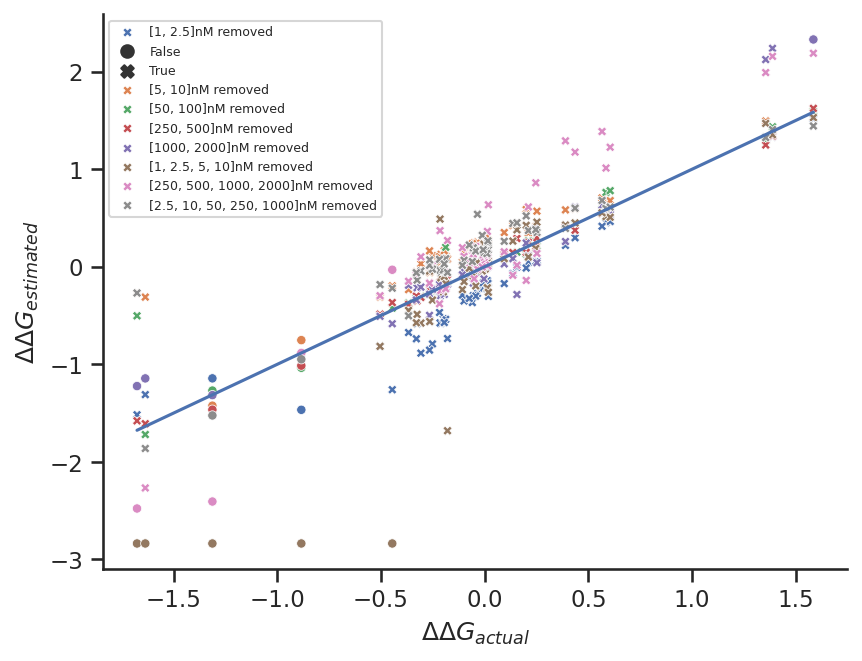

In [9]:
# remove two or more concentrations
all_concs = [
    [1, 2.5],
    [5, 10],
    [50, 100],
    [250, 500],
    [1000, 2000],
]  # , [1, 2.5, 5, 10], [250, 500, 1000, 2000], [2.5, 10, 50, 250, 1000]]
conc_to_ignore = [0, 25, 2000]
all_tests = []
test_all_concs = run_mle(
    input_df,
    conc_to_ignore,
    sigma=1.02,
    B=350,
    kd_guesses=kd_guesses,
    fmax_guesses=fmax_guesses,
    variant_col="Barcode",
    top25_only=True,
    highmid_only=False,
    plot=False,
    print_df=False,
)

for i in range(len(all_concs)):
    conc_to_ignore = [0, 25, 2000] + all_concs[i]
    all_tests.append(
        run_mle(
            input_df,
            conc_to_ignore,
            sigma=1.02,
            B=350,
            kd_guesses=kd_guesses,
            fmax_guesses=fmax_guesses,
            variant_col="Barcode",
            top25_only=True,
            highmid_only=False,
            plot=False,
            print_df=False,
        )
    )

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 150,
    "savefig.dpi": 300,
}
sns.set(rc=custom_params, style="ticks")
for i, df in enumerate(all_tests):
    s = test_all_concs["Success"] & df["Success"]
    sns.scatterplot(
        x=test_all_concs["ddg"],
        y=df["ddg"],
        s=20,
        style=s,
        label=(str(all_concs[i]) + "nM removed"),
    )
    print(
        "MSE conc=",
        all_concs[i],
        "removed:",
        MSE(test_all_concs["ddg"][s], df["ddg"][s]),
    )
plt.plot(
    [min(test_all_concs["ddg"]), max(test_all_concs["ddg"])],
    [min(test_all_concs["ddg"]), max(test_all_concs["ddg"])],
)
plt.xlabel(r"$\Delta\Delta G_{actual}$")
plt.ylabel(r"$\Delta\Delta G_{estimated}$")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=6, loc="best")
plt.show()

['M59I', 'M59I,S7T', 'S7T', 'Q120K,V109L', 'Q120K,S7T', 'M59I,T94M', 'S7T,P18P', 'M59I,T94M,D110E', 'T94M,V109L,D110E', 'Q120K,S7T,T94M,D110E']
[[12.49, 25.11, 17.96, 24.54, 36.77, 45.41, 85.56, 56.79, 79.81, 291.62], [17.67, 53.46, 28.25, 44.58, 122.57, 116.06, 111.26, 131.81, 211.66, 10429.19]]


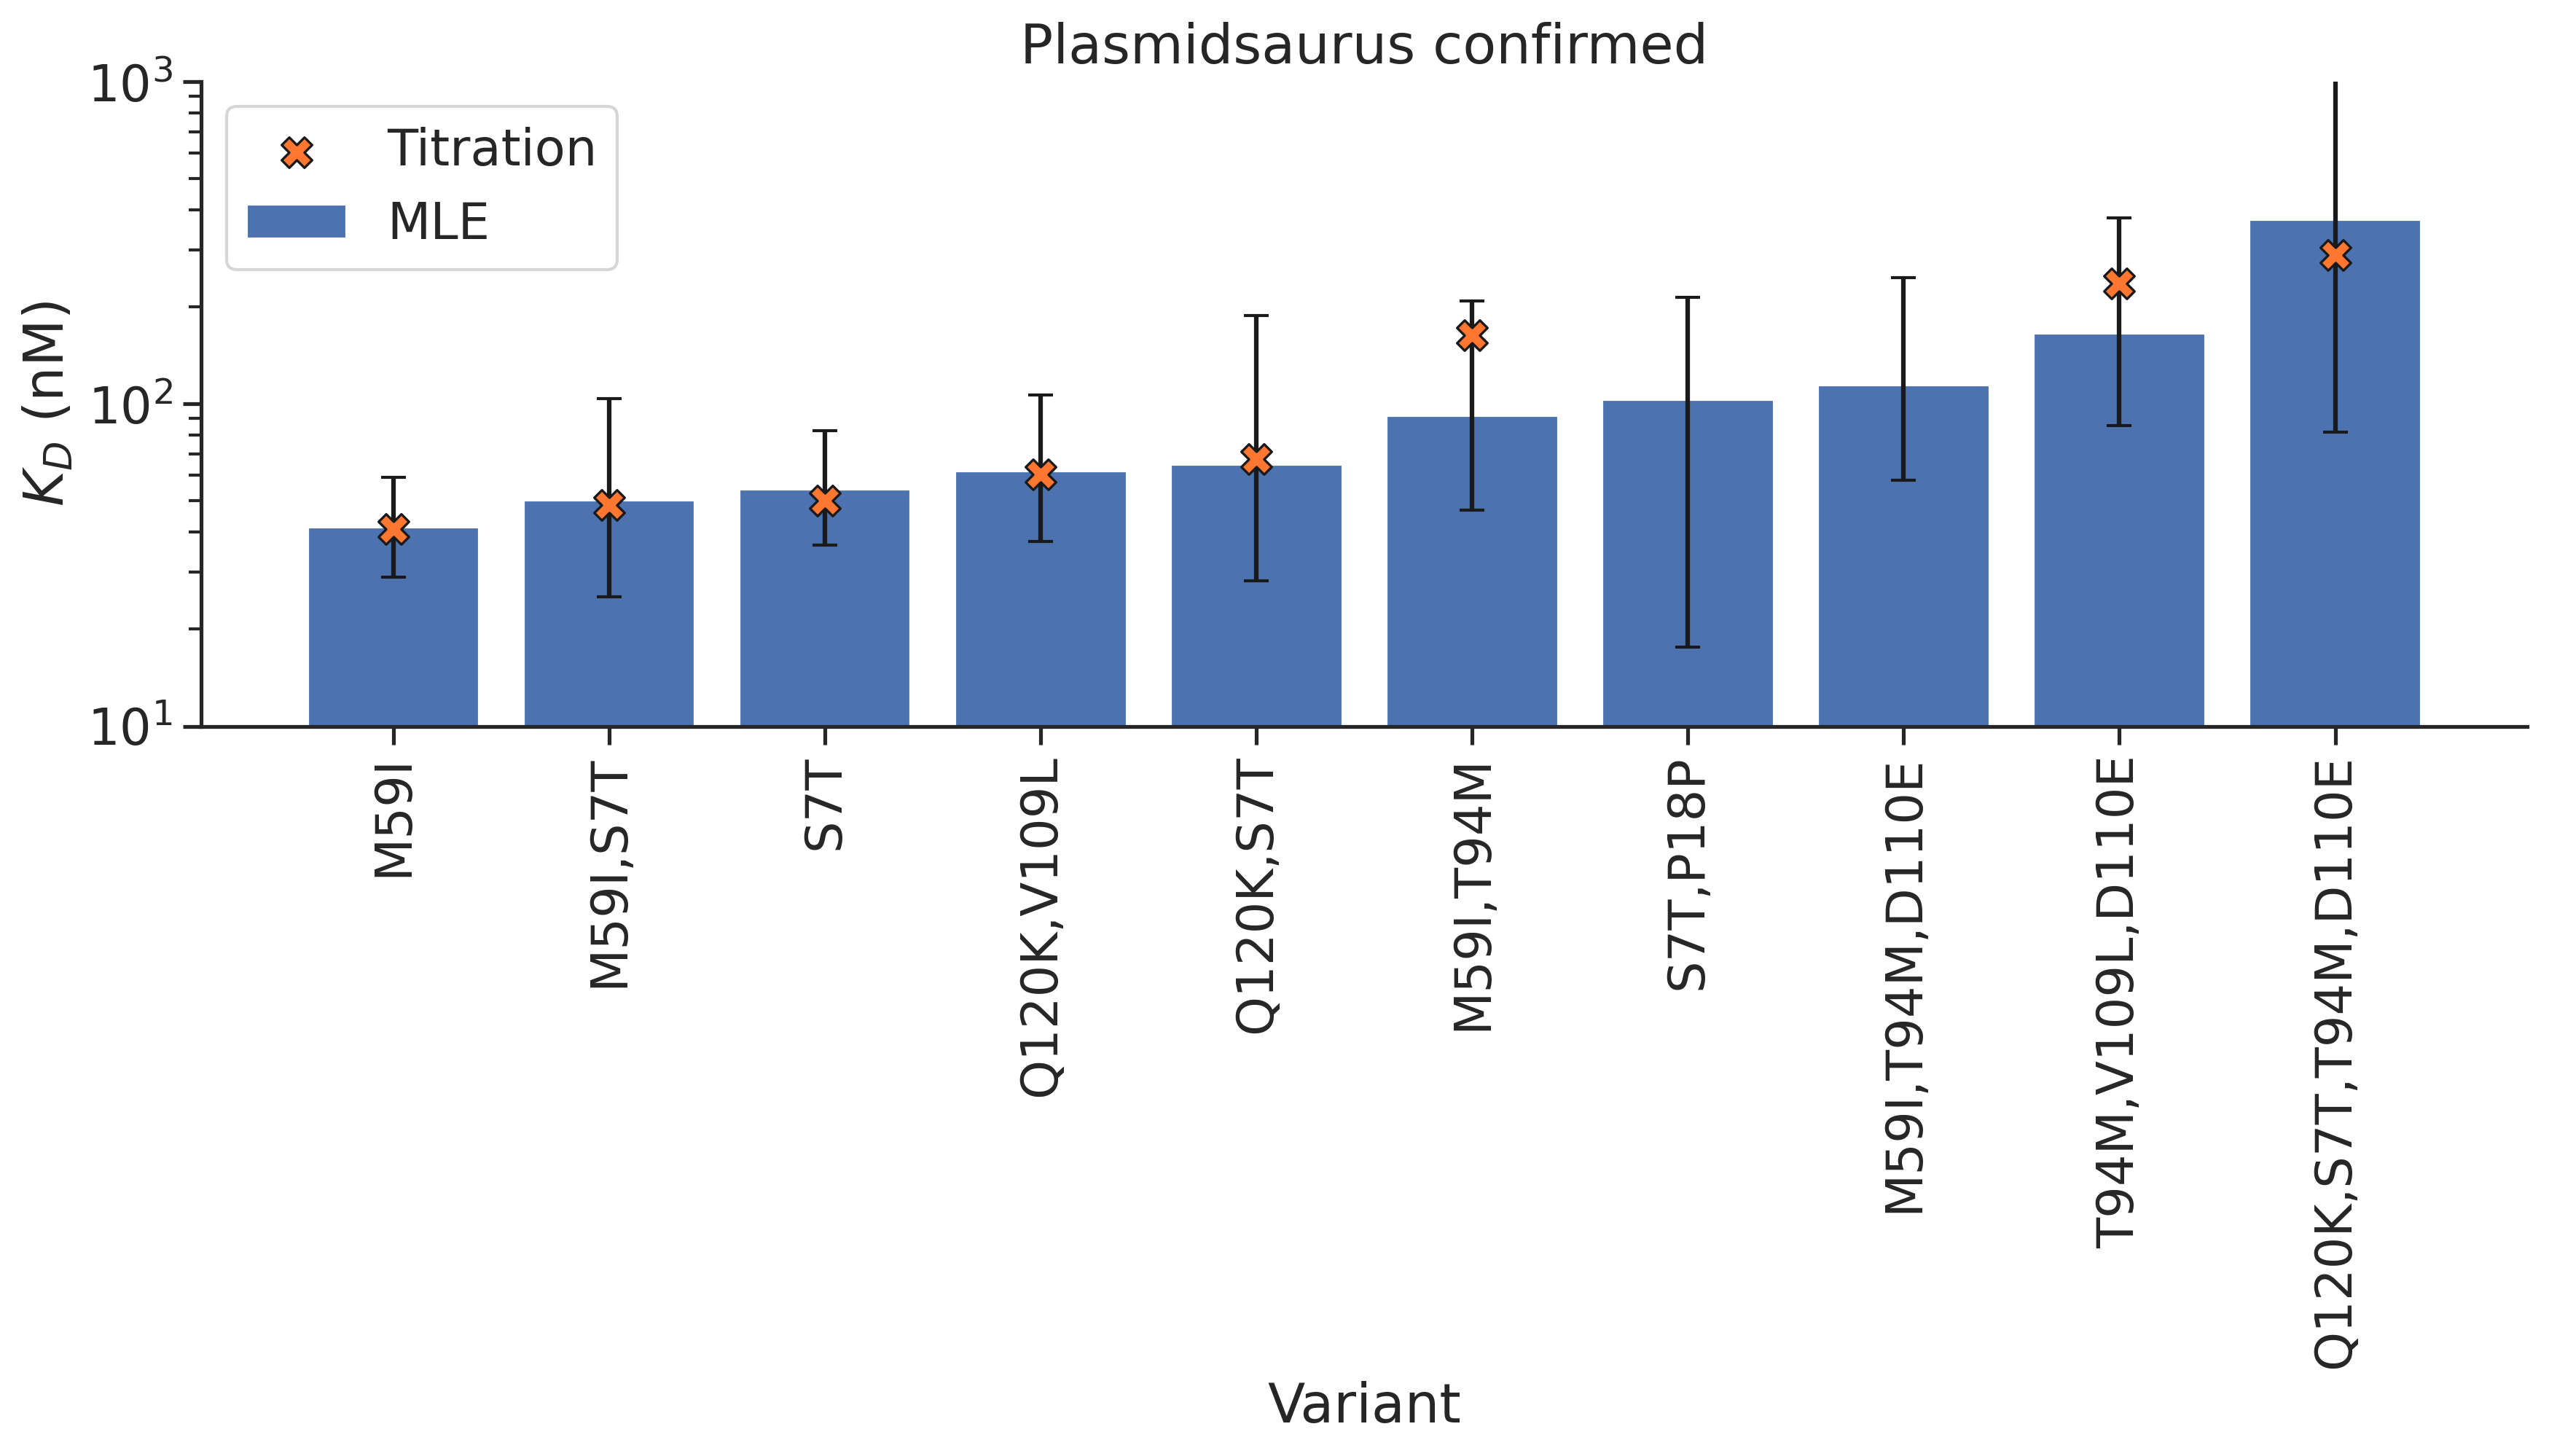

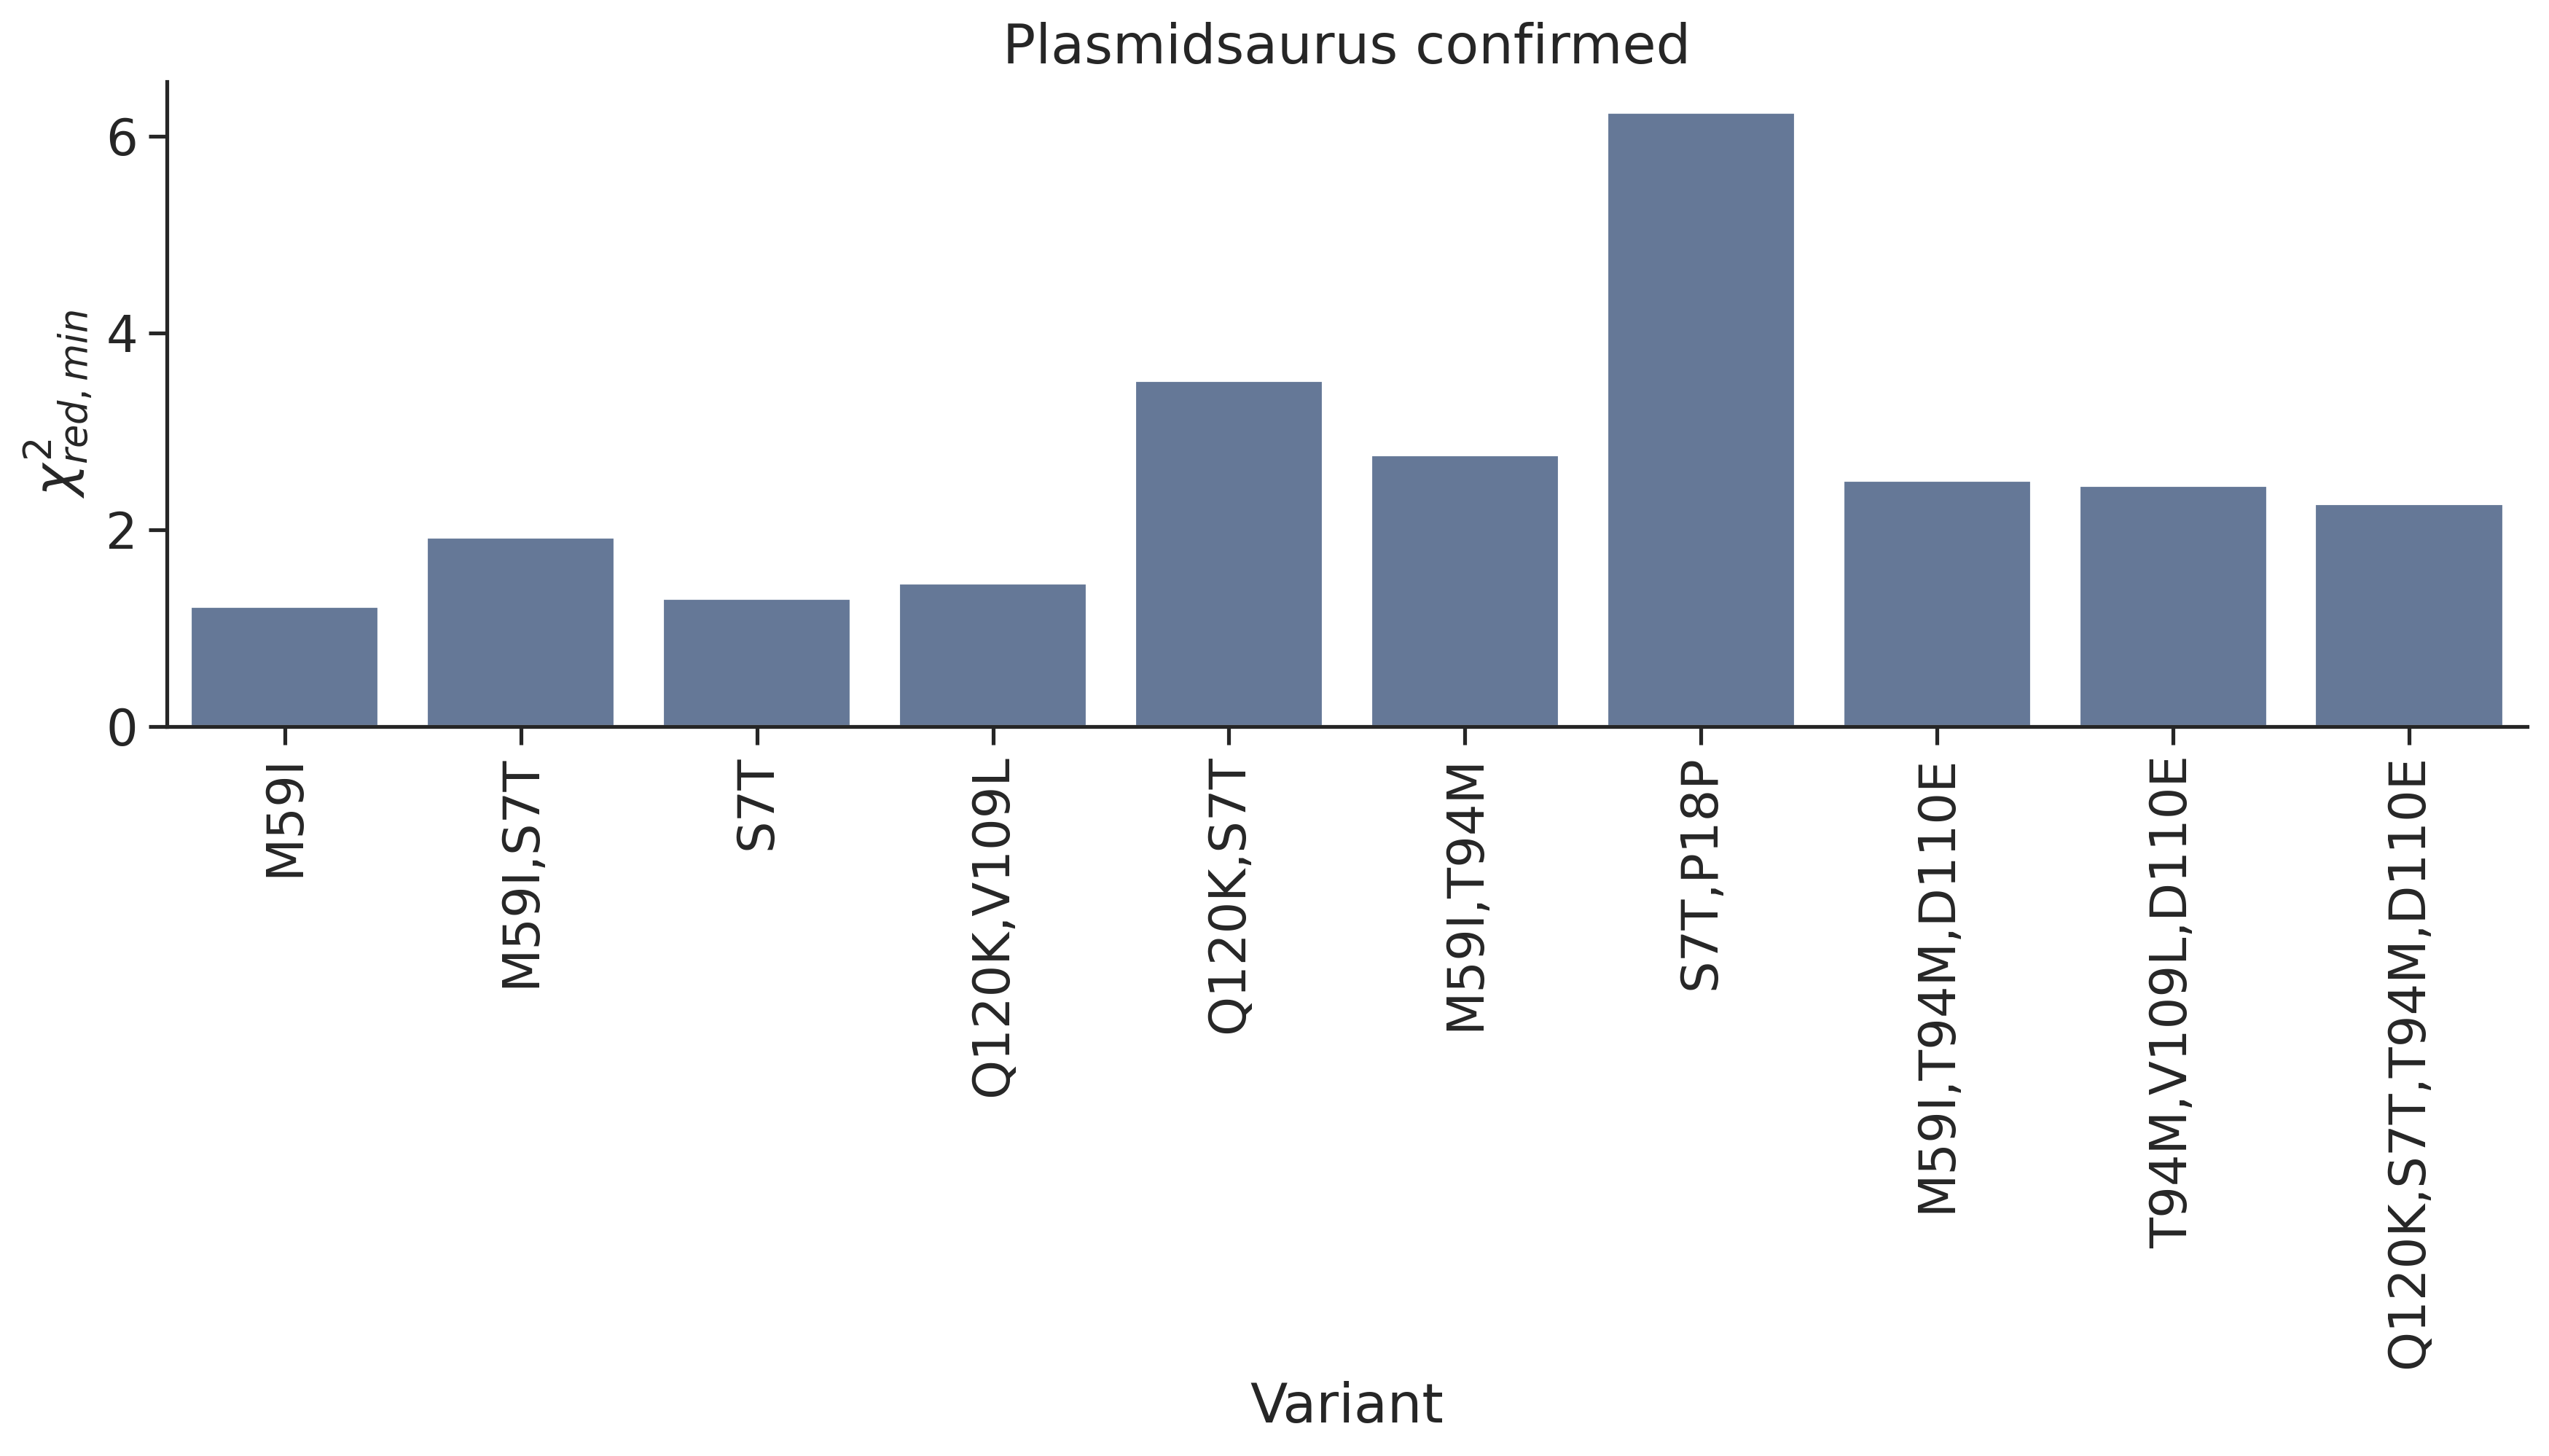

In [5]:
palette = sns.color_palette()
palette1 = [palette[i] for i in [0]]
# plt.style.use('fivethirtyeight')
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "figure.figsize": (12, 7),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)

df_titration = pd.read_csv("titration_data/MBK_titration.csv")
variants = [
    "S7T",
    "M59I",
    "M59I,S7T",
    "Q120K,S7T",
    "Q120K,S7T,T94M,D110E",
    "T94M,V109L,D110E",
    "M59I,T94M",
    "Q120K,V109L",
]
df_titration = df_titration[df_titration["Variant"].isin(variants)]
df = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/4A8_plasmidsaurus_mle.csv")
df = df.sort_values("Kd")
df["Variant"] = df["Variant"].apply(extract_mutations_from_str)
print(df["Variant"].to_list())
low, high = relative_cis(
    df["Kd"].to_list(), df["95% CI low"].to_list(), df["95% CI high"].to_list()
)
error = [low, high]
print(error)
sns.barplot(data=df, x="Variant", y="Kd", label="MLE", palette=palette1, saturation=1)
plt.errorbar(
    x=df["Variant"], y=df["Kd"], yerr=error, fmt="none", capsize=4, ecolor="k", zorder=1
)
sns.scatterplot(
    data=df_titration,
    x="Variant",
    y="Kd",
    label="Titration",
    color="#FF7730",
    marker="X",
    edgecolor="k",
    s=100,
)
plt.yscale("log")
plt.title("Plasmidsaurus confirmed")
plt.ylim((10, 1000))
plt.xticks(rotation=90)
plt.ylabel(r"$K_D$ (nM)")
plt.tight_layout()
# plt.savefig("titration_data/titration_comparison.png")
plt.show()
sns.barplot(data=df, x="Variant", y="X^2_red_min", palette=palette1, saturation=0.5)
plt.xticks(rotation=90)
plt.ylabel(r"$\chi^2_{red,min}$")
plt.title("Plasmidsaurus confirmed")
plt.tight_layout()
# plt.savefig("chi_sq.png")
plt.show()

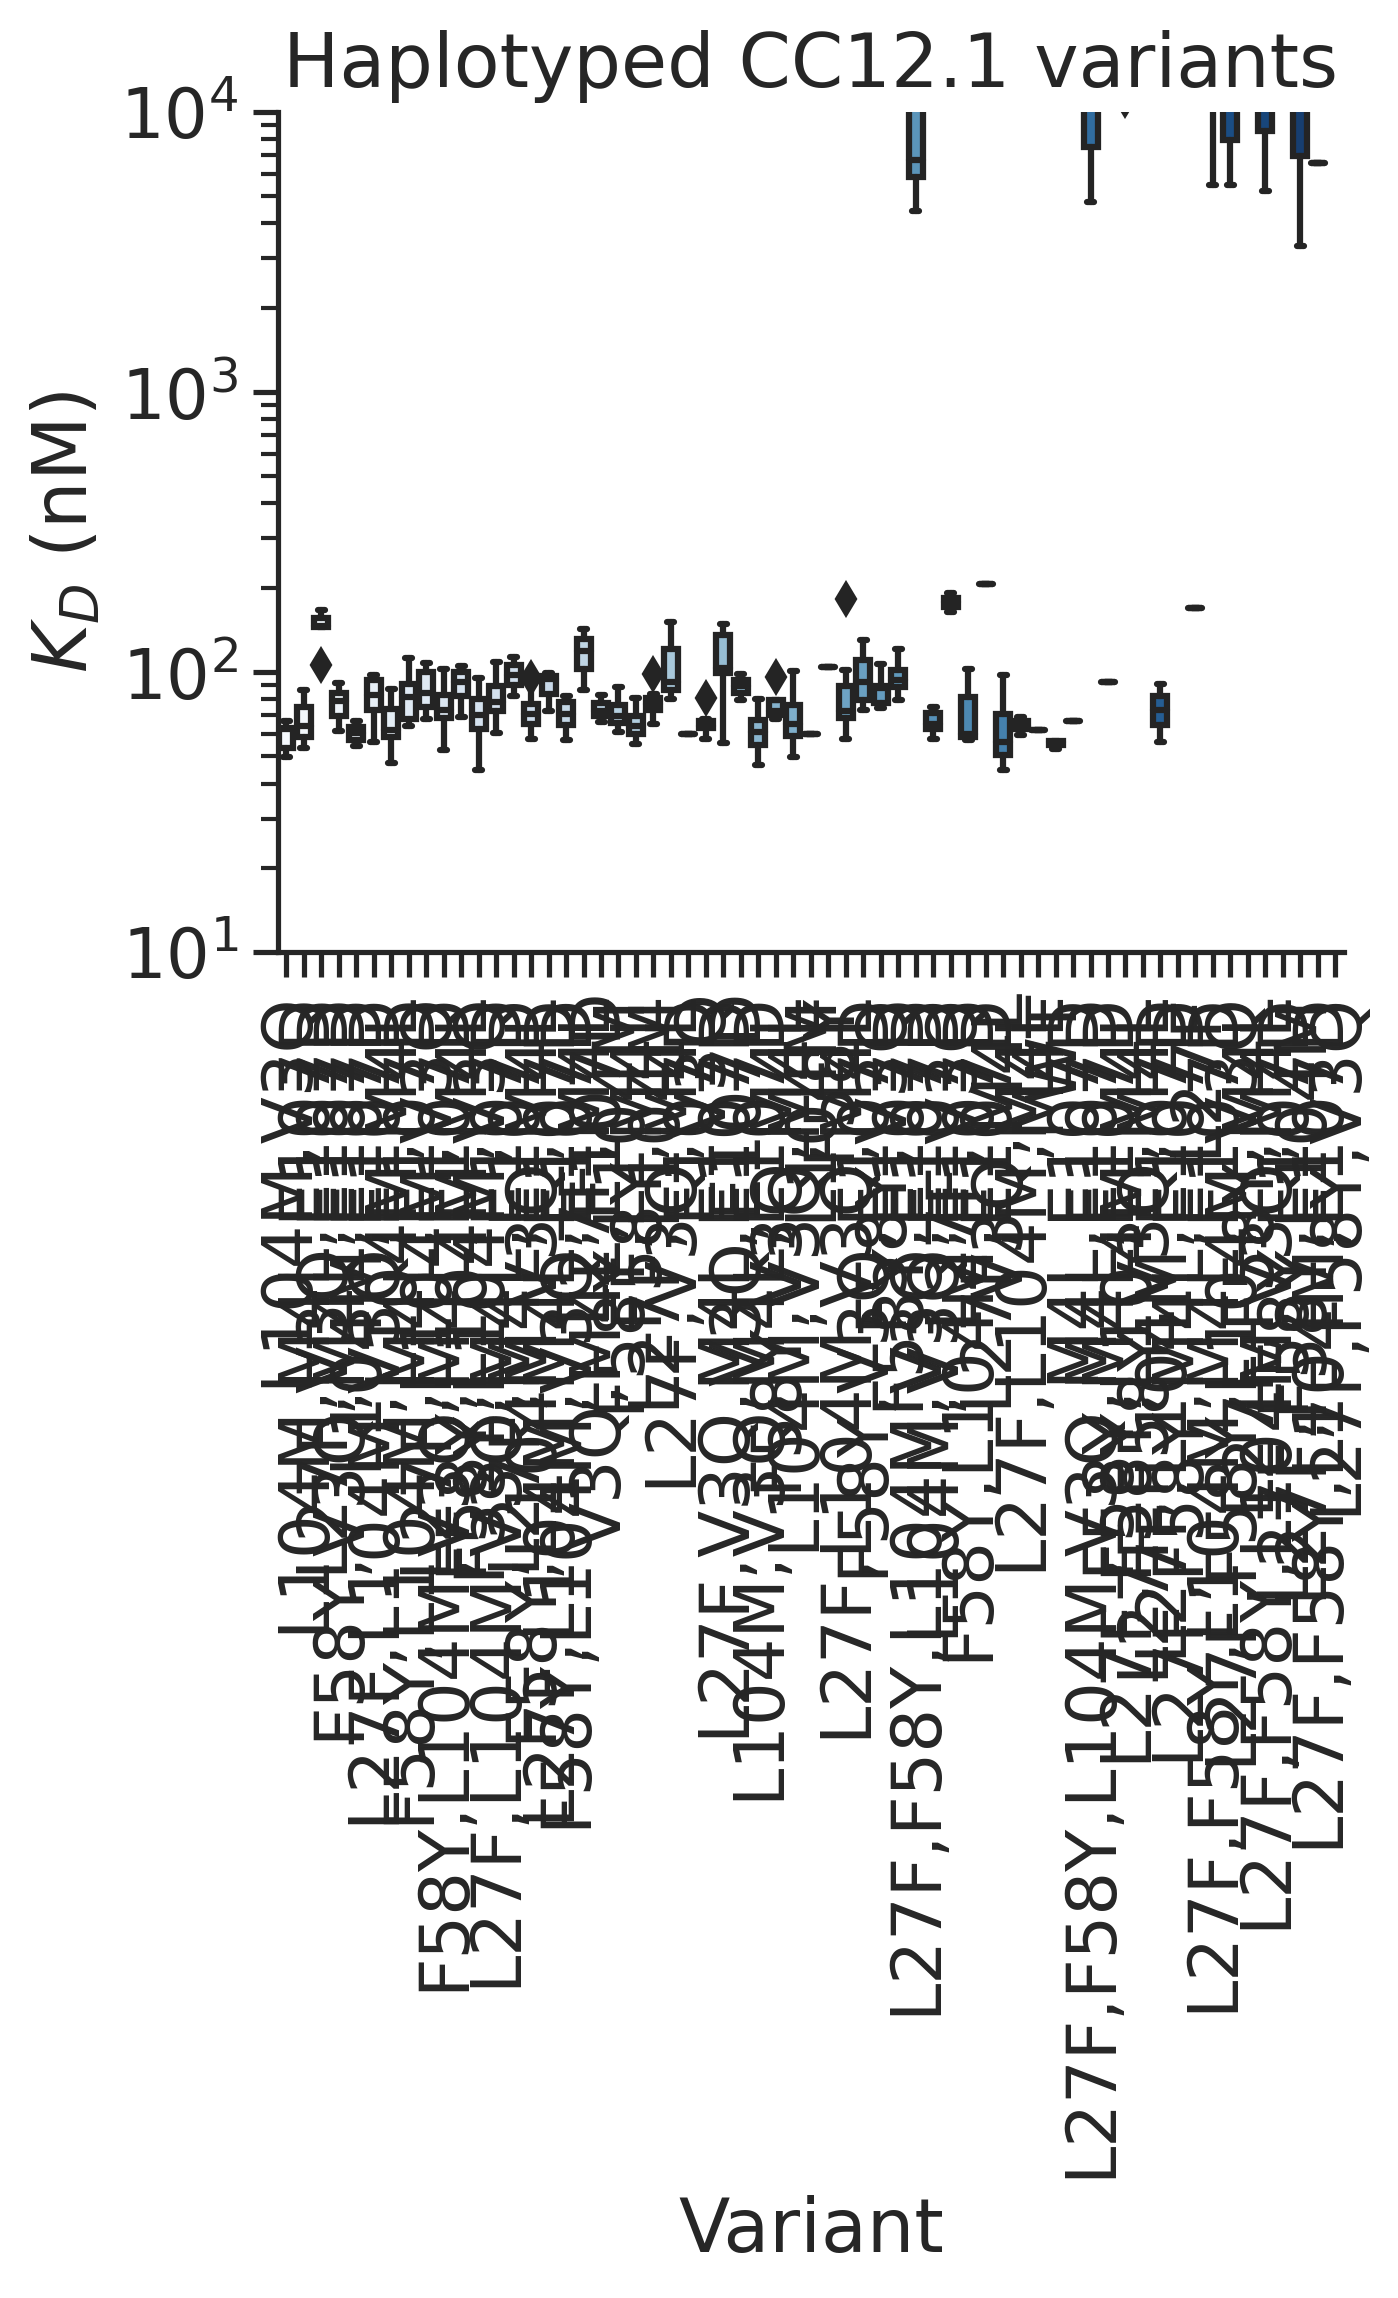

In [7]:
df = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/4A8_CC121_combined_mle_all.csv")
df = df[df["n"] == 9]
df = df[df["Variant"].str.startswith("CC121")]
df["Variant"] = df["Variant"].apply(extract_mutations_from_str)
# print(df["Variant"].to_list())
sns.boxplot(data=df, x="Variant", y="Kd", palette="Blues")
plt.yscale("log")
plt.ylim((10, 10**4))
plt.title("Haplotyped CC12.1 variants")
plt.xticks(rotation=90)
plt.ylabel(r"$K_D$ (nM)")
plt.tight_layout()
# plt.savefig("titration_comparison_haplotyped_all.png")
plt.show()

                  Barcode              Variant      Kd      Fmax  Success  \
391  TTTGGTACGAAGGAATACAT  4A8>VH:WT|4A8>VL:WT   65.87  13821.36     True   
392  ACGCGATGCAGGAAAGGCGC  4A8>VH:WT|4A8>VL:WT   55.26  14739.58     True   
393  AAGTAATTACGTAAATCTTG  4A8>VH:WT|4A8>VL:WT   72.69  13694.47     True   
394  TCAGCCTGCCGCCAAGATTT  4A8>VH:WT|4A8>VL:WT   67.71  12761.53     True   
395  AATGACGCGTAGCCGGATGC  4A8>VH:WT|4A8>VL:WT   73.03  15171.55     True   
396  ACTTCATTCAATCAGTACGC  4A8>VH:WT|4A8>VL:WT   46.57  19975.00     True   
397  TTATGCTCGAATCCAGGAGC  4A8>VH:WT|4A8>VL:WT  154.39   7739.51     True   
398  TTGTCTAGGTAGGTATACGG  4A8>VH:WT|4A8>VL:WT   77.34  12310.55     True   
399  TTACGTAGAAGGGAGCGAAC  4A8>VH:WT|4A8>VL:WT   86.06  16741.61     True   
400  CCTCGTGGCATGCATGGATG  4A8>VH:WT|4A8>VL:WT  138.87   9614.86     True   
401  TTTCACTGATTTCCTGGCTT  4A8>VH:WT|4A8>VL:WT   61.75  14167.35     True   
402  CATGGTTCATAGCTATACTT  4A8>VH:WT|4A8>VL:WT   65.25  12978.57     True   

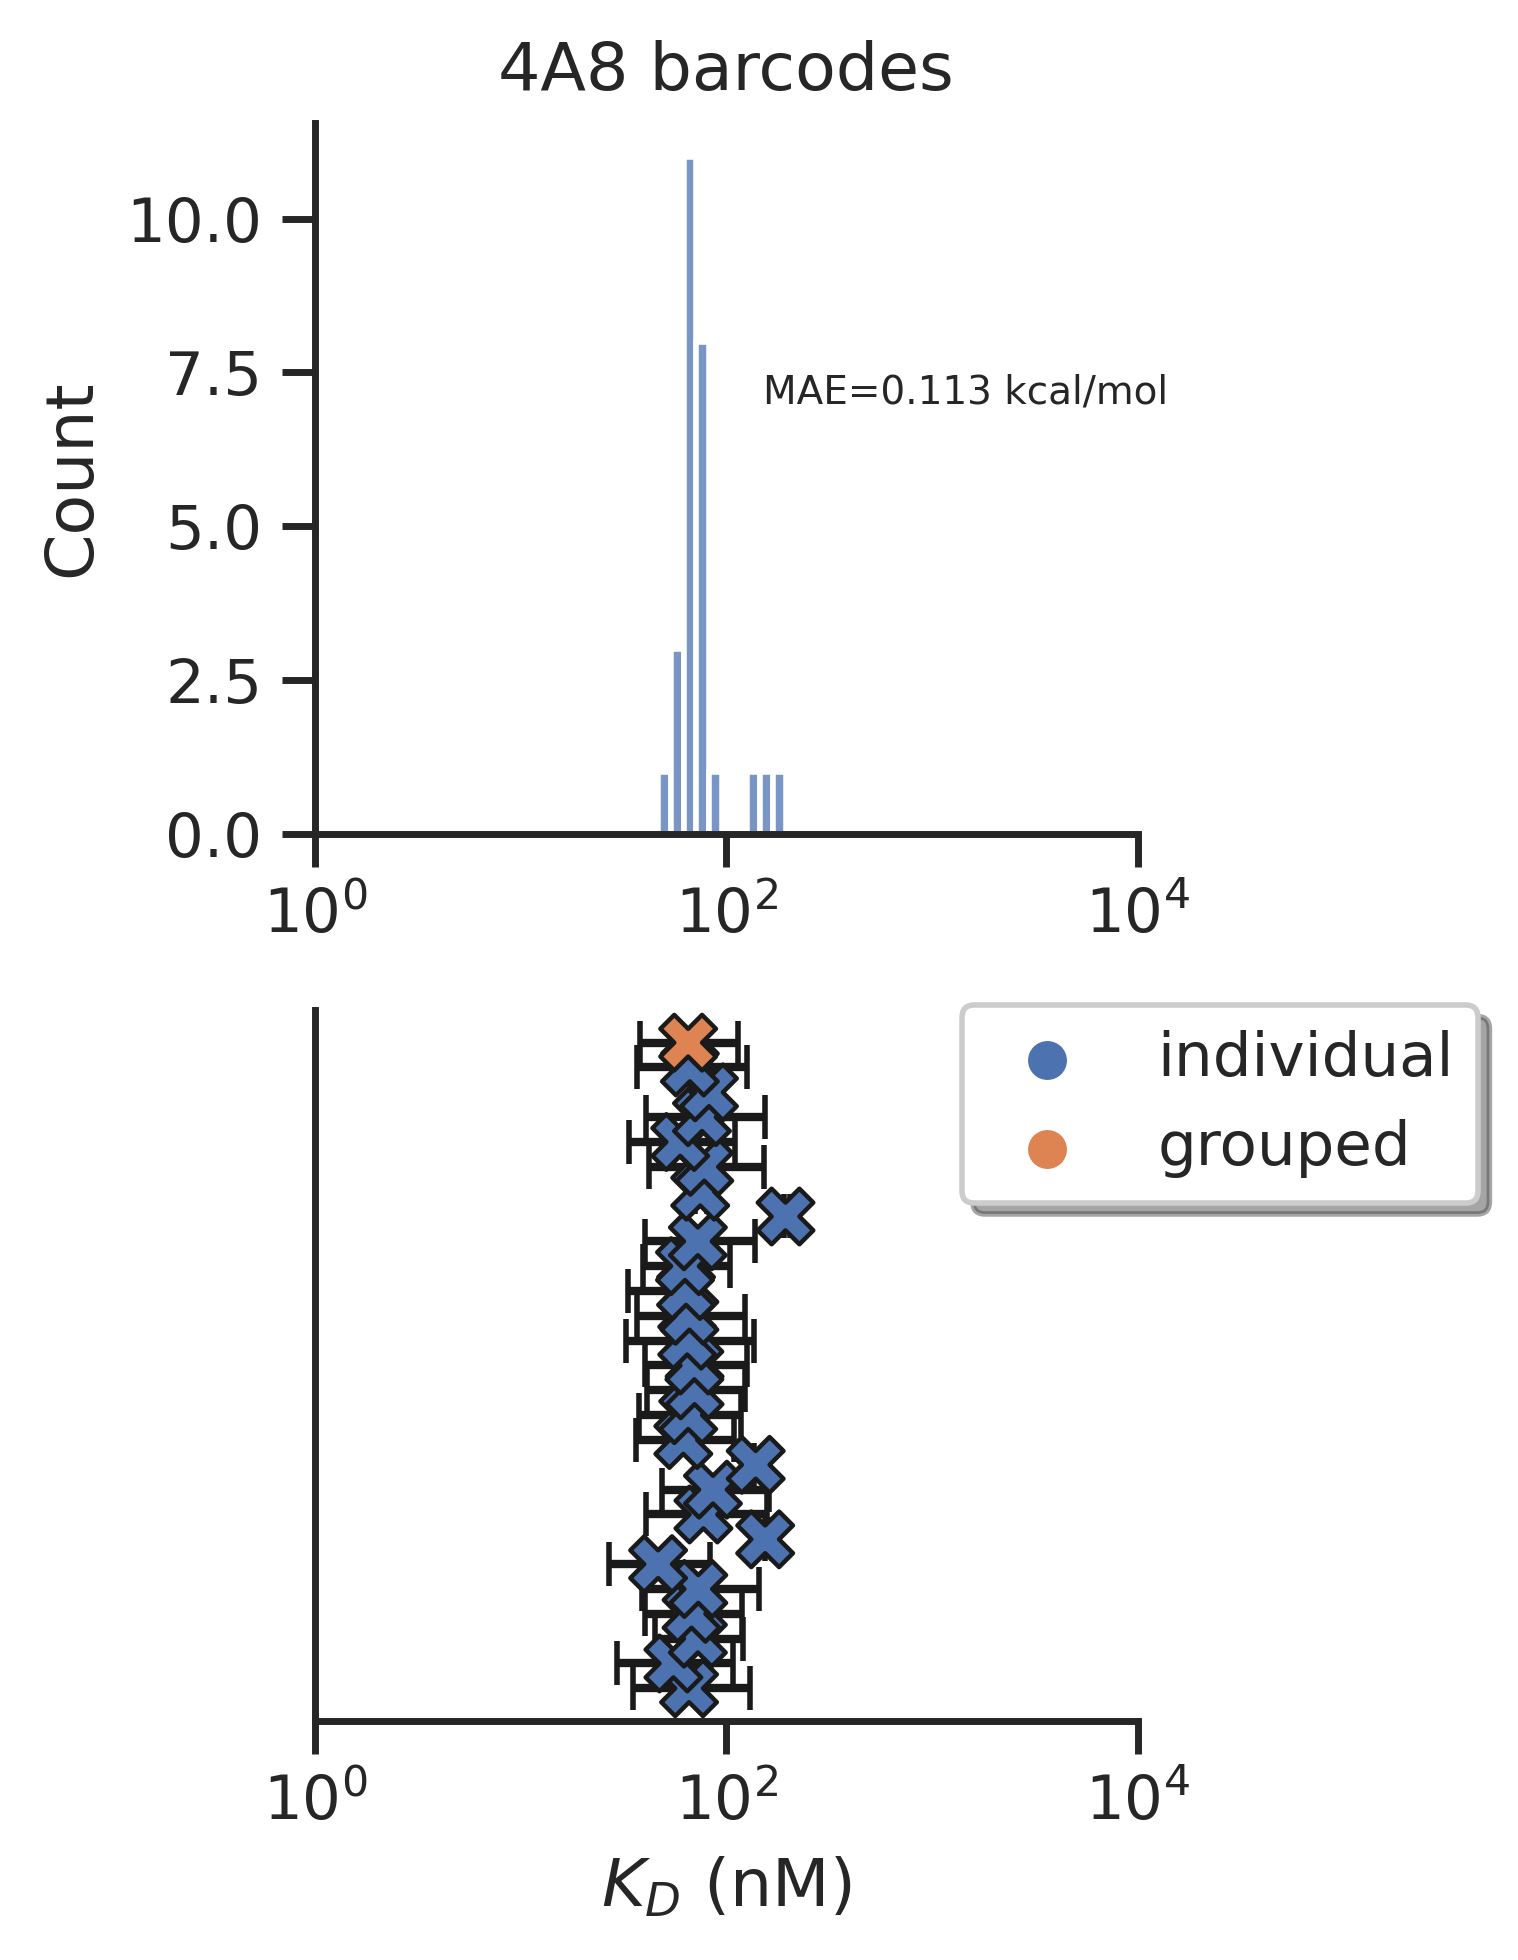

In [9]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 400,
    "savefig.dpi": 600,
    "figure.figsize": (4, 5),
    "font.size": 10,
}
sns.set(rc=custom_params, style="ticks")
df = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/all_barcodes.csv")
df2 = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/combine_top25-50_test1.csv")
df['Dataset'] = "individual"
df2['Dataset'] = 'grouped'
df = pd.concat([df, df2])
#df = df[df["n"] == 9]
df = df[df["Variant"] == "4A8>VH:WT|4A8>VL:WT"]
df = df[df["95% CI low"] != 0]
df = df[df["95% CI high"] != 0]
df = df[df["95% CI high"] != df["95% CI low"]]
print(df)

kds_outlier_removed = [kd_to_ddg(k, 70.75) for k in df["Kd"].to_list() if k < 200]
print(kds_outlier_removed)
mae = [abs(obs) for obs in kds_outlier_removed]
mae = np.mean(mae)
print("MAE: ", mae)

limits = (1, 10000)
low, high = relative_cis(df["Kd"].to_list(), df["95% CI low"].to_list(), df["95% CI high"].to_list())
error = [low, high]
plt.subplot(211)
sns.histplot(x=df["Kd"], log_scale=10, bins=10)
plt.title("4A8 barcodes")
plt.text(150,7,f"MAE={round(mae,3)} kcal/mol", fontsize=7)
plt.xlabel("")
plt.xscale("log")
plt.xlim(limits)
plt.subplot(212)
sns.scatterplot(
    data=df,
    x="Kd",
    y=range(len(df)),
    hue="Dataset",
    marker="X",
    edgecolor="k",
    s=100,
    zorder=1,
)
plt.errorbar(
    x=df["Kd"],
    y=range(len(df)),
    xerr=error,
    fmt="none",
    capsize=4,
    ecolor="k",
    zorder=-1,
)
print(error)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticks([])
plt.xlim(limits)
plt.xscale("log")
plt.xlabel(r"$K_D$ (nM)")
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1.05), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("/projects/brpe7306/fab-library-barcoding/MLE/output/WT_bcs.png")
plt.show()

[0.262, 0.347, 0.188, 0.04, 0.247, 0.557, 0.145, 0.734, 0.286, 0.739, 0.165, 0.092, 0.005, 0.179, 0.308, 0.114, 0.616, 0.272, 0.078, 0.135, 0.602, 0.136, 0.162, 0.13, 0.028, 0.134, 0.21, 0.258, 0.592, 0.408, 0.152]
MAE:  0.2684193548387096
                  Barcode                    Variant      Kd      Fmax  \
128  ATGCACACATTTAAAGCTGT  4A8>VH:M59I-ATC|4A8>VL:WT   52.28  16168.45   
129  TAGTGCTTGTTTGTTGGTTG  4A8>VH:M59I-ATC|4A8>VL:WT  238.55   6575.06   
130  CTTTATTCAATTCTGCACTT  4A8>VH:M59I-ATC|4A8>VL:WT   60.20  15873.43   
131  AATGAAGCAAGTGAGTGTGT  4A8>VH:M59I-ATC|4A8>VL:WT   66.45  15902.33   
132  ACGGATAGCATGGAGGATAG  4A8>VH:M59I-ATC|4A8>VL:WT   51.38  15312.33   
133  CAACAAACGAGTCTACAATT  4A8>VH:M59I-ATC|4A8>VL:WT   64.47  17537.06   
134  TCTGCTTCATATCTTTATAT  4A8>VH:M59I-ATC|4A8>VL:WT   48.64  14311.32   
135  TAAGAATGGCTCCATGGAGC  4A8>VH:M59I-ATC|4A8>VL:WT   63.00  15704.37   
136  TCGTACATACGTCATTACAC  4A8>VH:M59I-ATC|4A8>VL:WT   61.32  21056.45   
137  TTTCCTATACGTGTT

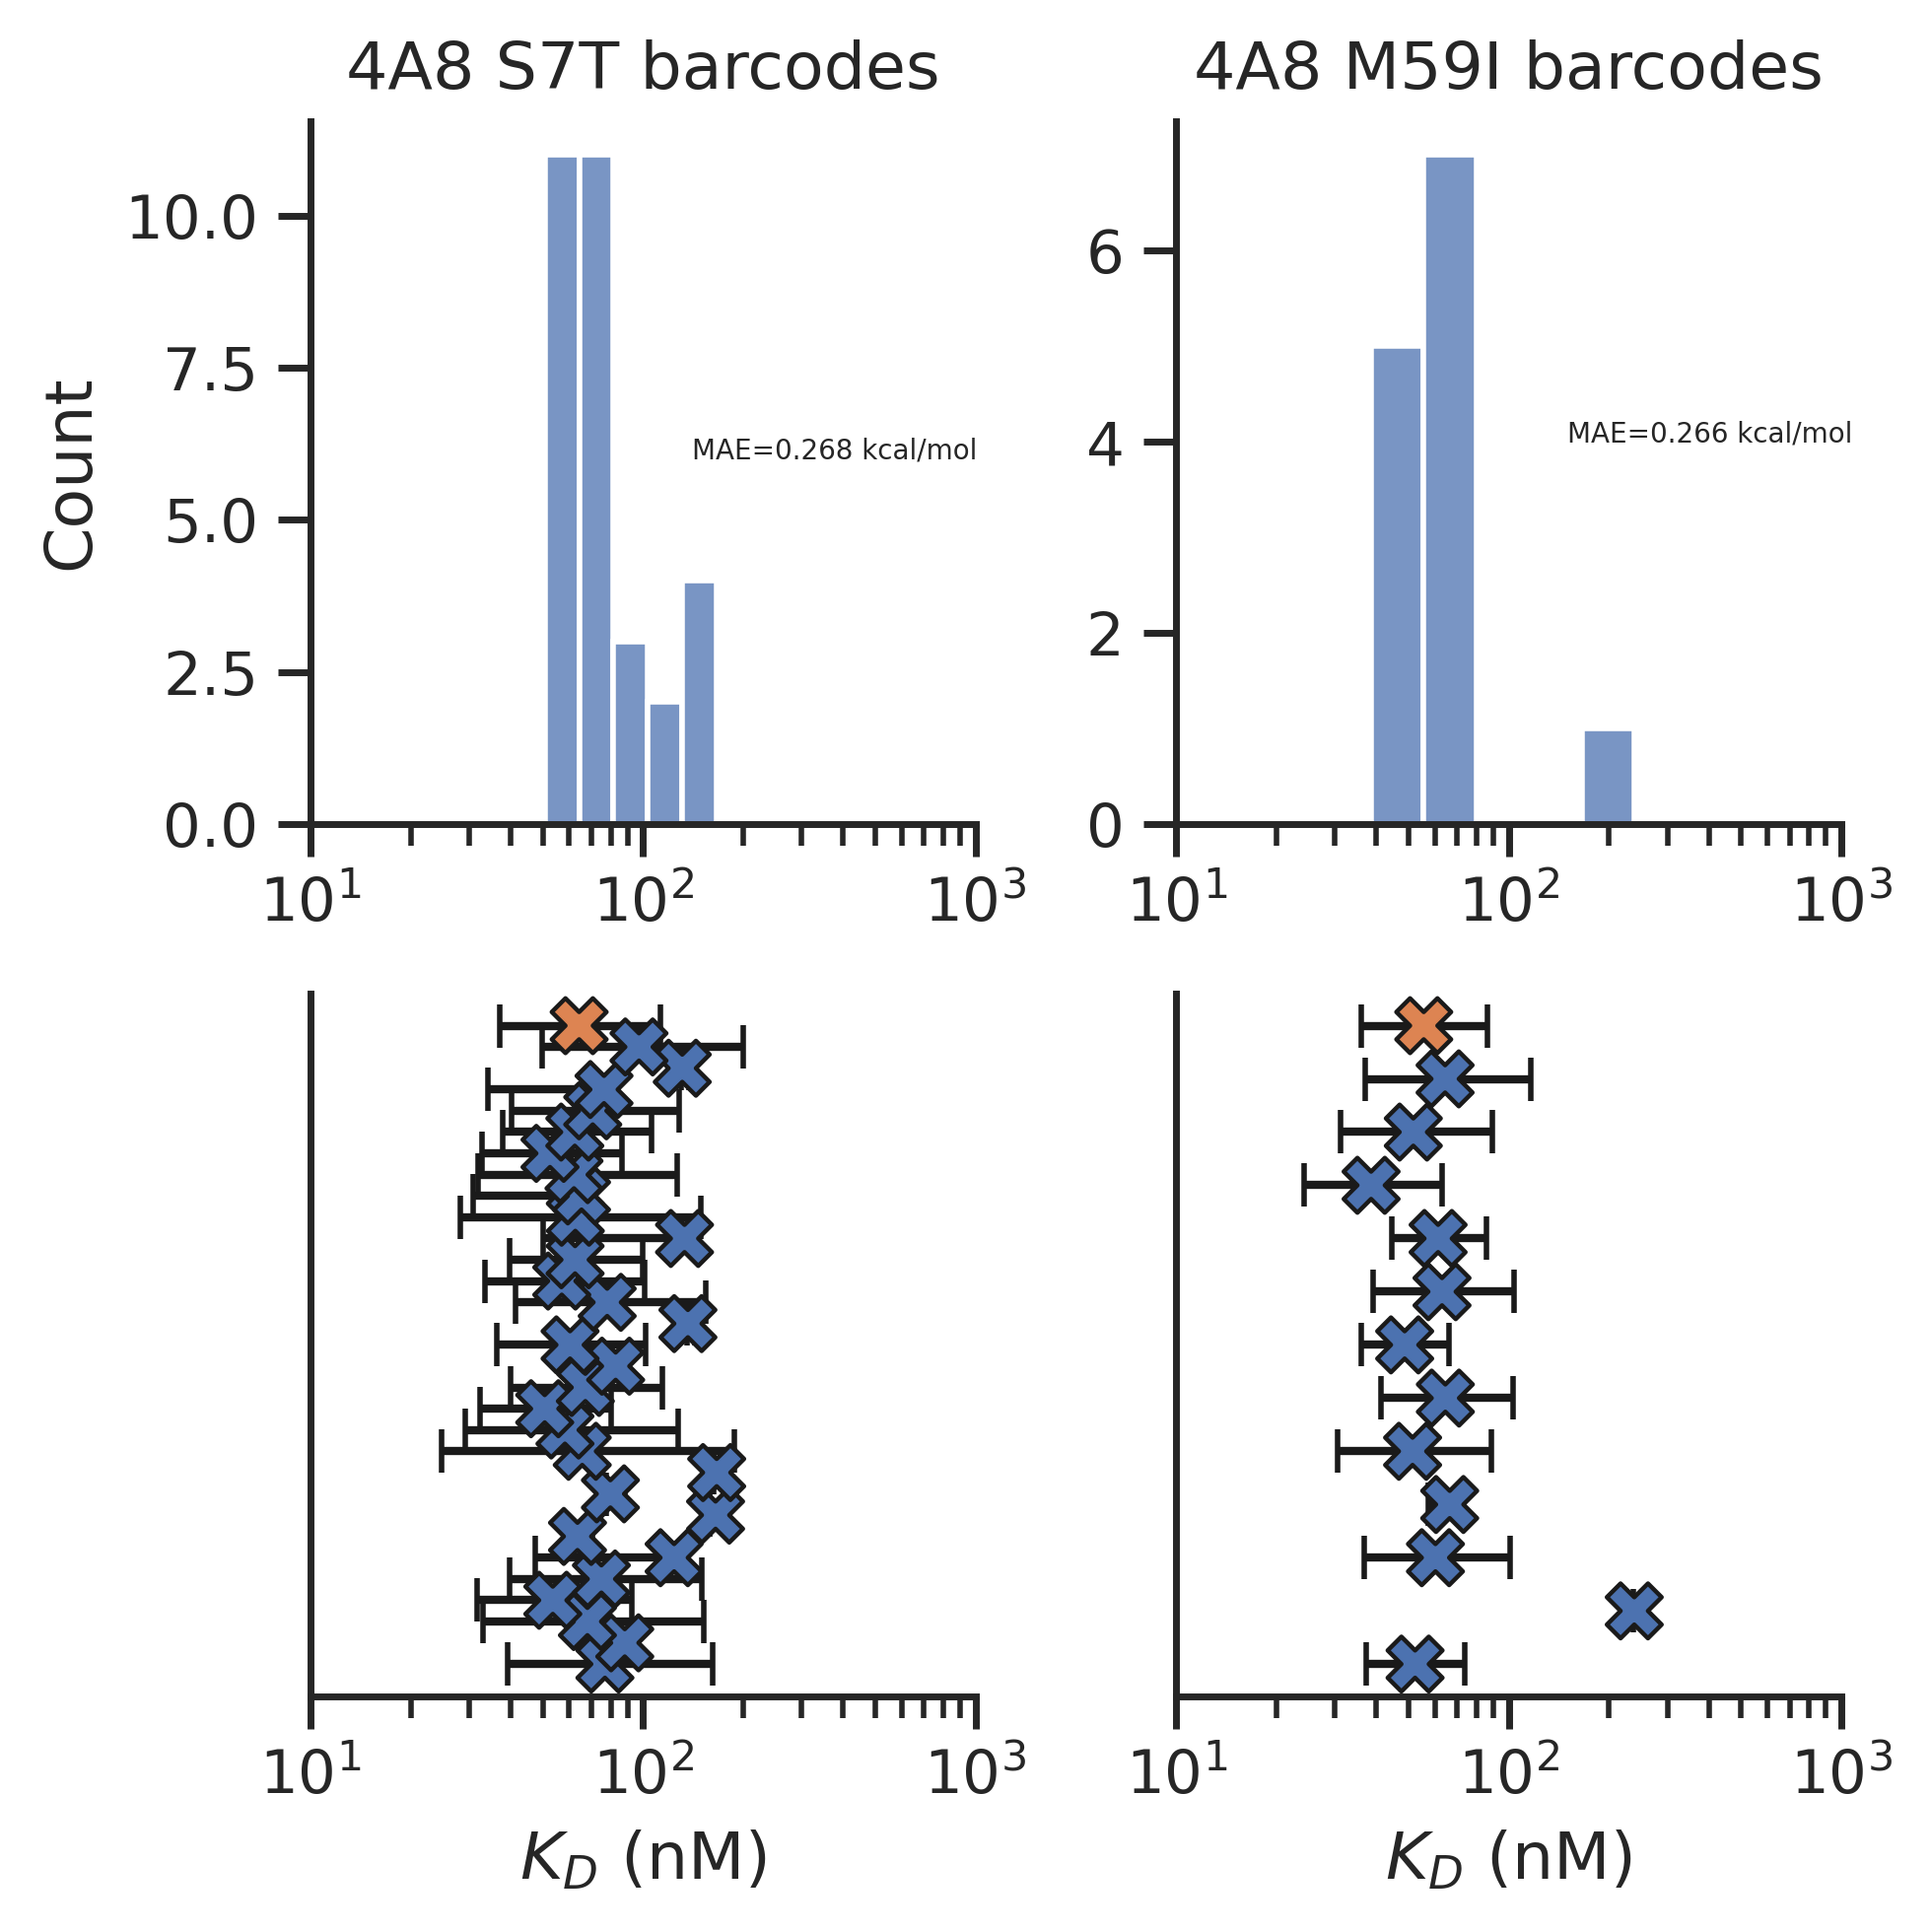

In [27]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 400,
    "savefig.dpi": 600,
    "figure.figsize": (5, 5),
    "font.size": 10,
}
sns.set(rc=custom_params, style="ticks")
df = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/all_barcodes.csv")
df2 = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/combine_top25-50_test1.csv")
df['Dataset'] = "individual"
df2['Dataset'] = 'grouped'
df = pd.concat([df, df2])
#df = df[df["n"] == 9]
df = df[df["Variant"] == "4A8>VH:WT|4A8>VL:S7T-ACT"]
df = df[df["95% CI low"] != 0]
df = df[df["95% CI high"] != 0]

kds_outlier_removed = [kd_to_ddg(k, 50.2) for k in df["Kd"].to_list() if k < 20000]
print(kds_outlier_removed)
mae = [abs(obs) for obs in kds_outlier_removed]
mae = np.mean(mae)
print("MAE: ", mae)

limits = (10, 1000)
low, high = relative_cis(df["Kd"].to_list(), df["95% CI low"].to_list(), df["95% CI high"].to_list())
error = [low, high]
plt.subplot(221)
sns.histplot(x=df["Kd"], log_scale=10, bins=5)
plt.title("4A8 S7T barcodes")
plt.text(140,6,f"MAE={round(mae,3)} kcal/mol", fontsize=5)
plt.xlabel("")
plt.xscale("log")
plt.xlim(limits)
plt.subplot(223)
sns.scatterplot(
    data=df,
    x="Kd",
    y=range(len(df)),
    hue="Dataset",
    marker="X",
    edgecolor="k",
    s=100,
    zorder=1,
)
plt.errorbar(
    x=df["Kd"],
    y=range(len(df)),
    xerr=error,
    fmt="none",
    capsize=4,
    ecolor="k",
    zorder=-1,
)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticks([])
plt.xlim(limits)
plt.xscale("log")
plt.xlabel(r"$K_D$ (nM)")
plt.legend().set_visible(False)

df = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/all_barcodes.csv")
df2 = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/combine_top25-50_test1.csv")
df['Dataset'] = "individual"
df2['Dataset'] = 'grouped'
df = pd.concat([df, df2])
#df = df[df["n"] == 9]
df = df[df["Variant"] == "4A8>VH:M59I-ATC|4A8>VL:WT"]
df = df[df["95% CI low"] != 0]
df = df[df["95% CI high"] != 0]
print(df)
kds_outlier_removed = [kd_to_ddg(k, 40.9) for k in df["Kd"].to_list() if k < 20000]
print(kds_outlier_removed)
mae = [abs(obs) for obs in kds_outlier_removed]
mae = np.mean(mae)
print("MAE: ", mae)

low, high = relative_cis(df["Kd"].to_list(), df["95% CI low"].to_list(), df["95% CI high"].to_list())
error = [low, high]
plt.subplot(222)
sns.histplot(x=df["Kd"], log_scale=10, bins=5)
plt.title("4A8 M59I barcodes")
plt.text(150,4,f"MAE={round(mae,3)} kcal/mol", fontsize=5)
plt.xlabel("")
plt.ylabel("")
plt.xscale("log")
plt.xlim(limits)
plt.subplot(224)
sns.scatterplot(
    data=df,
    x="Kd",
    y=range(len(df)),
    hue="Dataset",
    marker="X",
    edgecolor="k",
    s=100,
    zorder=1,
)
plt.errorbar(
    x=df["Kd"],
    y=range(len(df)),
    xerr=error,
    fmt="none",
    capsize=4,
    ecolor="k",
    zorder=-1,
)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticks([])
plt.xlim(limits)
plt.xscale("log")
plt.xlabel(r"$K_D$ (nM)")
plt.ylabel("")
plt.legend().set_visible(False)
plt.tight_layout()
plt.savefig("/projects/brpe7306/fab-library-barcoding/MLE/output/T94M,S7T_bcs.png")
plt.show()

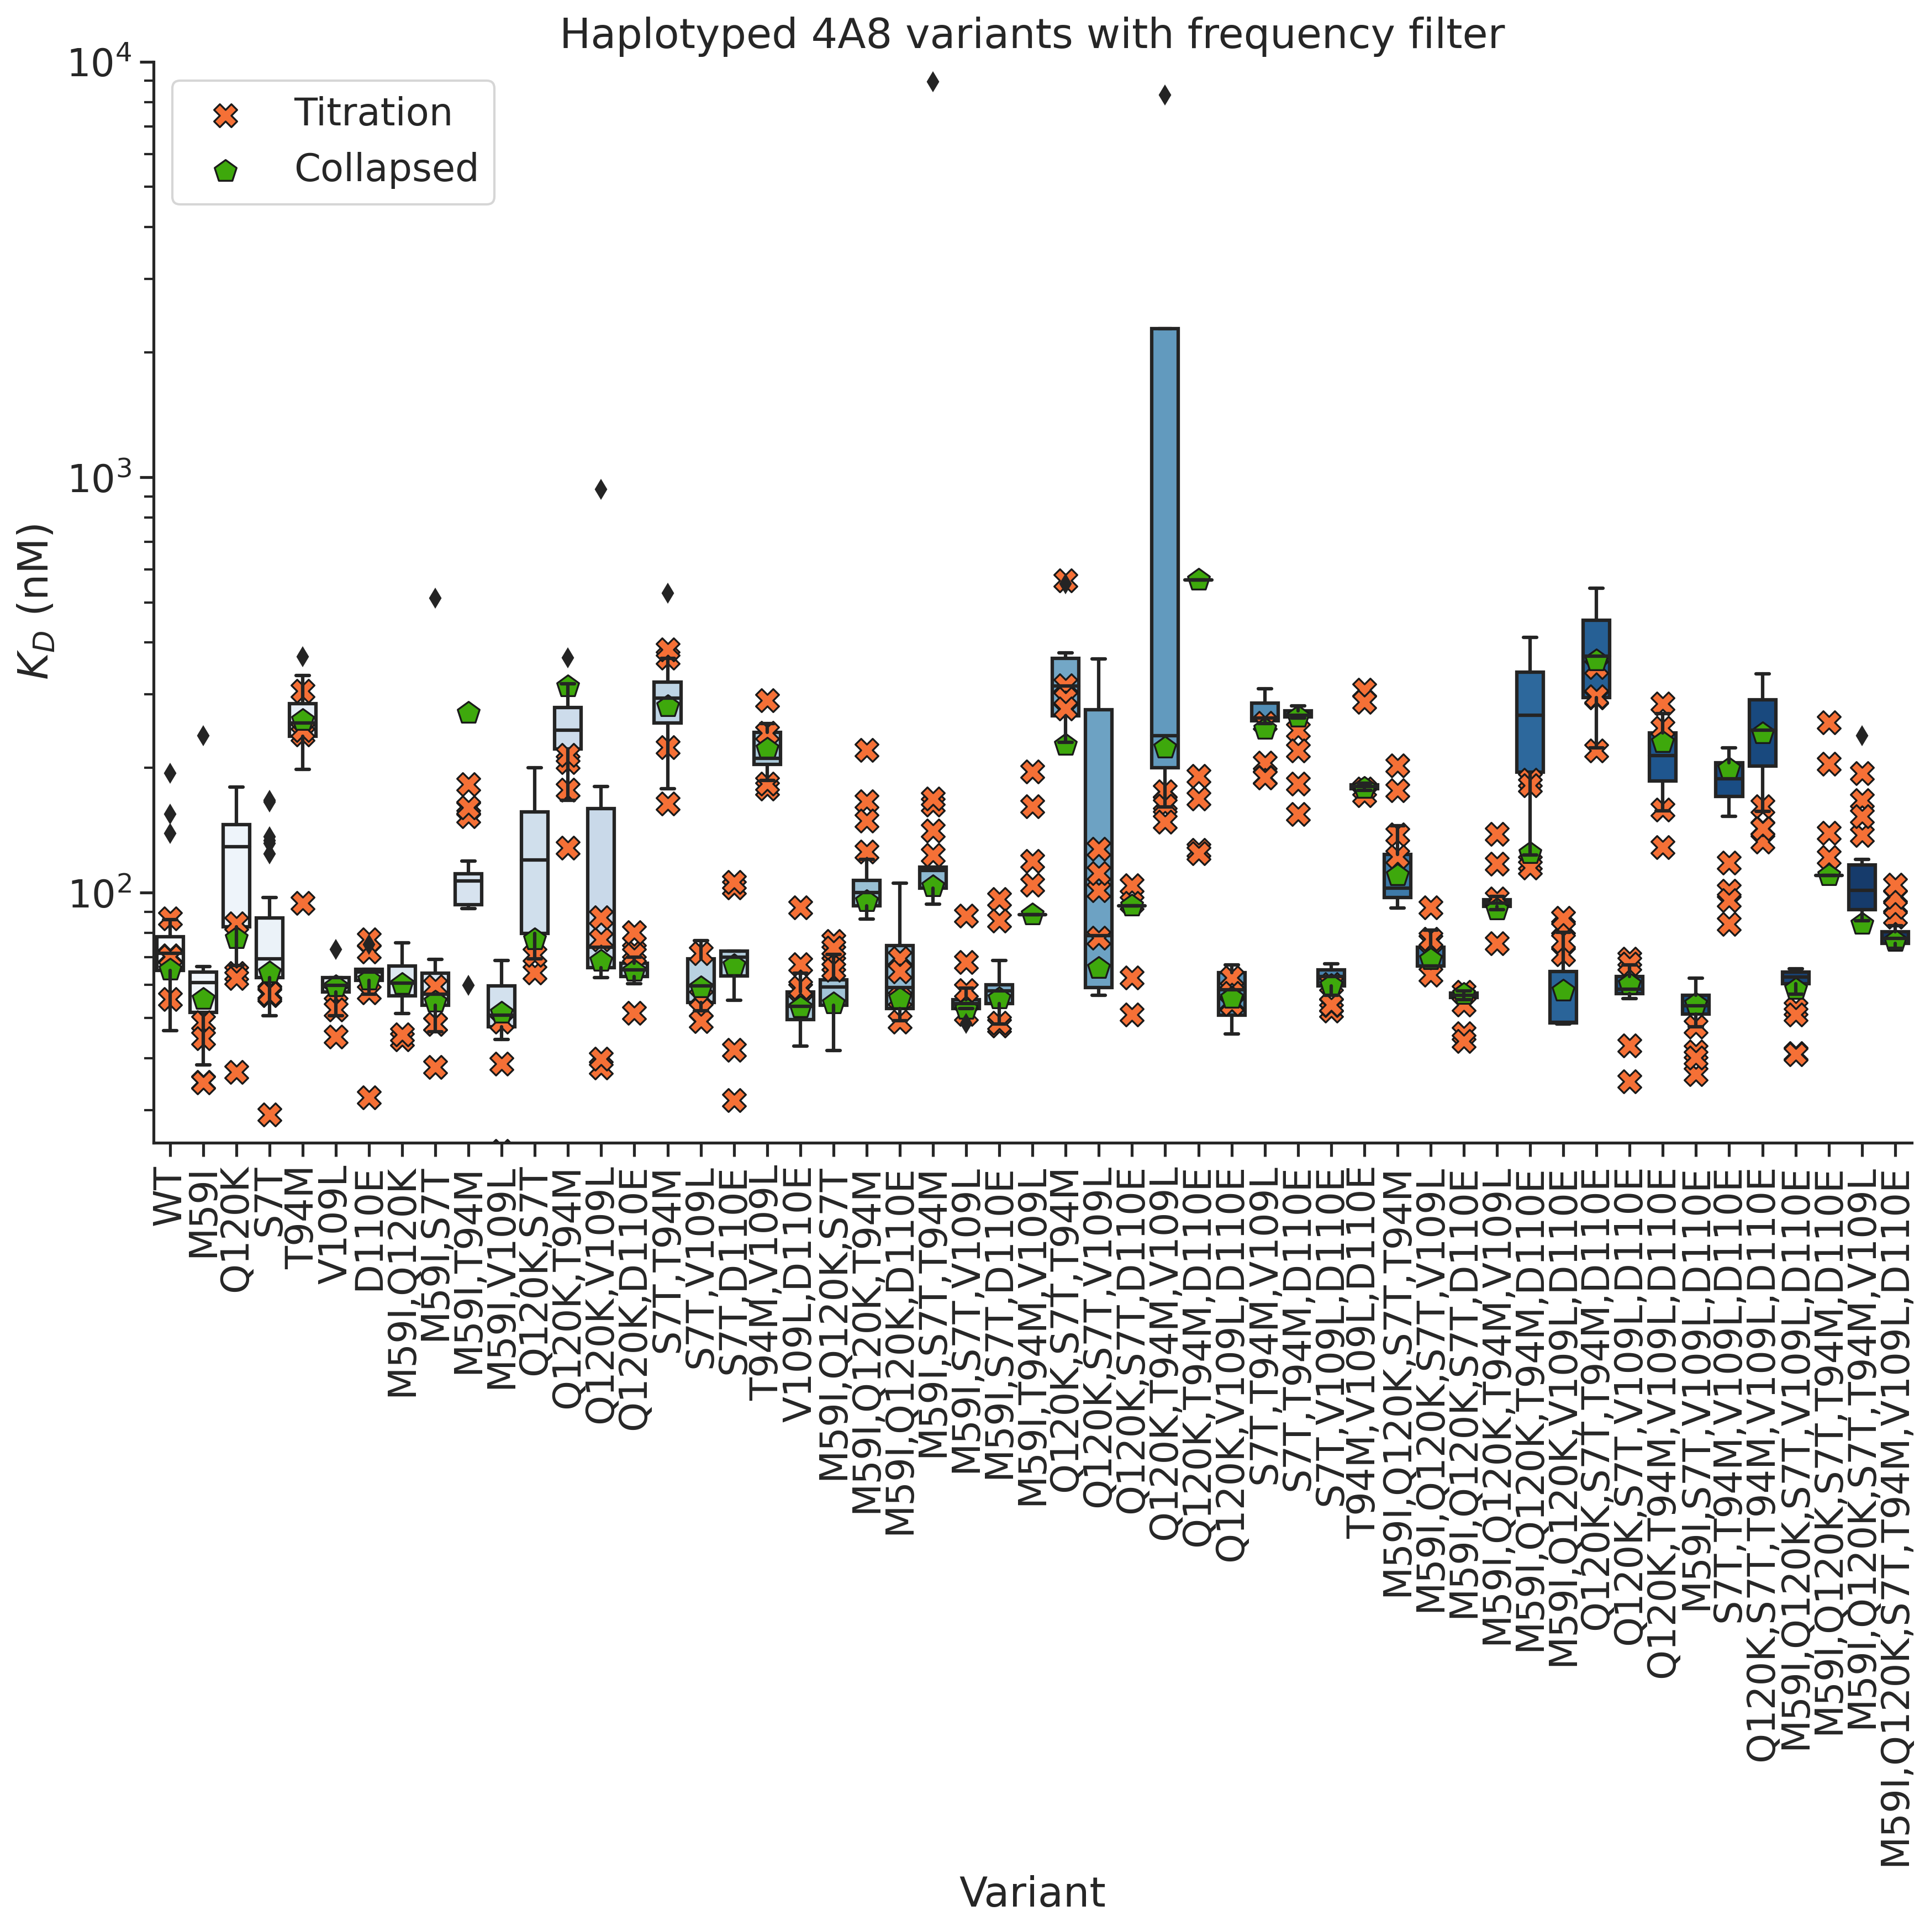

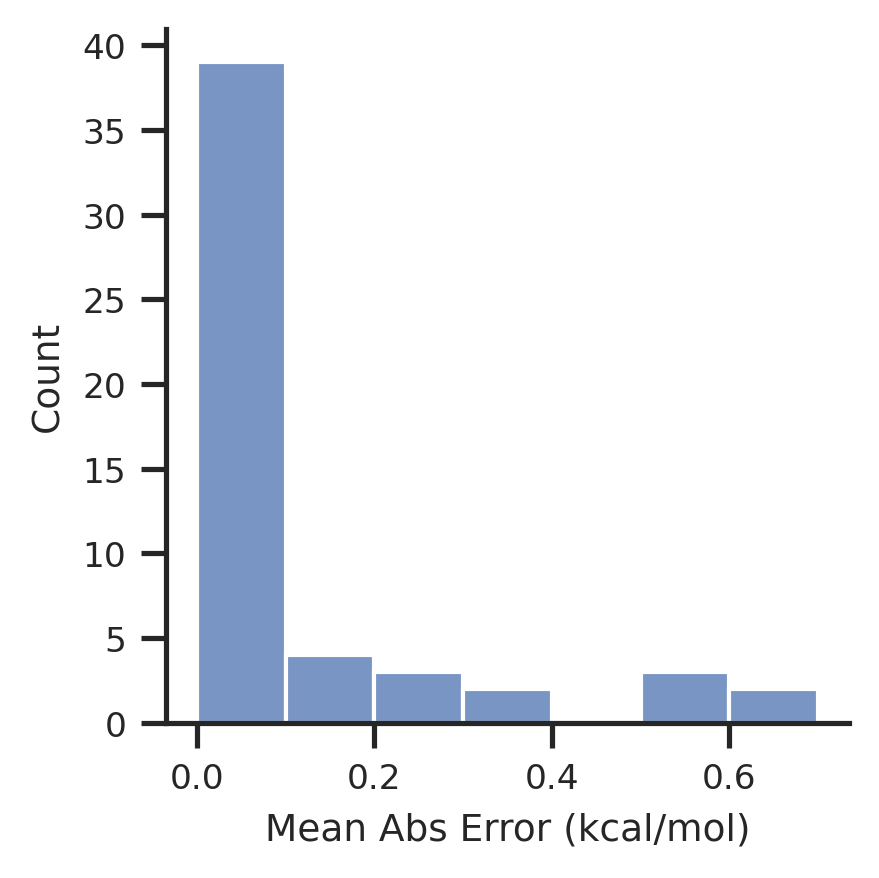

WT
[86.66, 55.51, 70.58, 70.25]
[65.2]
[37.96] [114.]
[0.05]
(-0.333, 0.344)

M59I
[35.07, 48.79, 44.65, 34.95]
[55.51]
[35.92] [86.36]
[0.189]
(-0.268, 0.272)

Q120K
[64.01, 36.98, 62.31, 84.35]
[77.74]
[43.48] [143.65]
[0.14]
(-0.358, 0.378)

S7T
[57.6, 56.68, 29.26, 57.12]
[64.28]
[37.09] [113.15]
[0.153]
(-0.339, 0.348)

T94M
[240.2, 94.3, 305.7, 246.3]
[259.87]
[257.25] [278.7]
[0.098]
(-0.006, 0.043)

V109L
[57.58, 52.31, 22.97, 44.96]
[59.43]
[39.76] [89.6]
[0.179]
(-0.248, 0.253)

D110E
[72.17, 77.19, 32.15, 57.45]
[61.68]
[41.16] [93.65]
[0.02]
(-0.249, 0.257)

M59I,Q120K
[44.27, 45.53]
[60.12]
[39.48] [92.39]
[0.18]
(-0.259, 0.265)

M59I,S7T
[59.52, 48.29, 38.05, 48.29]
[54.52]
[36.84] [81.04]
[0.072]
(-0.241, 0.244)

M59I,T94M
[159.6, 182.6, 152.5, 160.3]
[270.36]
[86.19] [290.99]
[0.309]
(-0.704, 0.045)

M59I,V109L
[48.96, 38.8, 23.89, 23.62]
[51.33]
[33.29] [80.31]
[0.257]
(-0.267, 0.276)

not found
Q120K,S7T
[64.25, 70.86]
[77.06]
[41.12] [150.22]
[0.081]
(-0.387, 0.411)


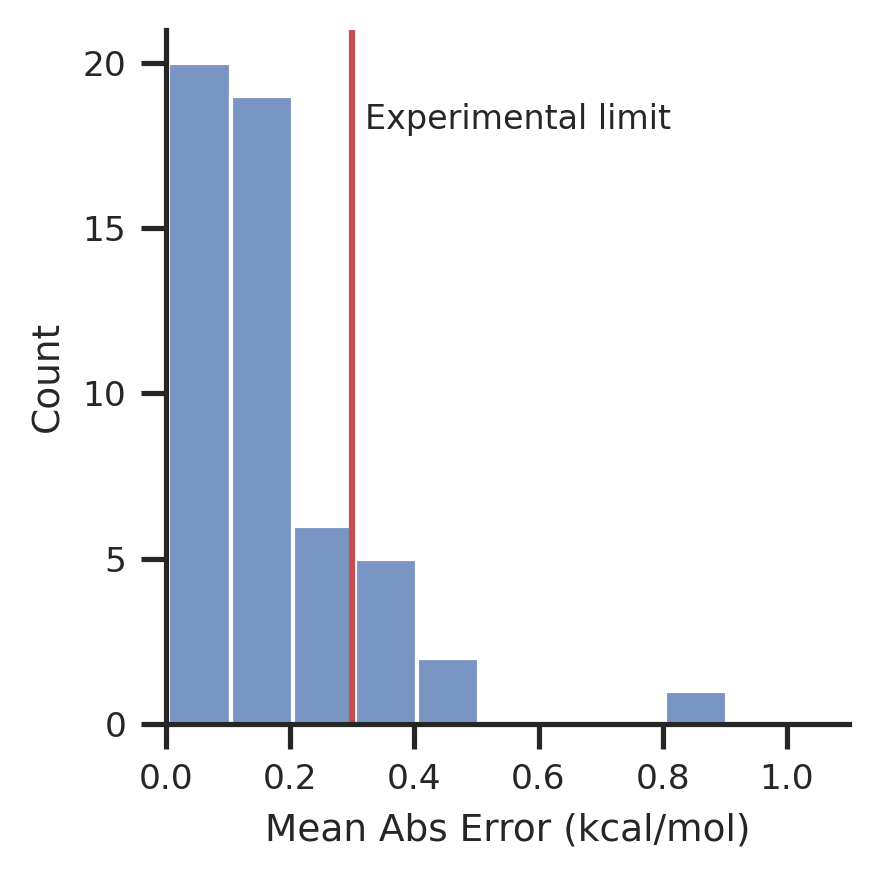

In [3]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "figure.figsize": (12, 12),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)
o = [
    "WT",
    "M59I",
    "Q120K",
    "S7T",
    "T94M",
    "V109L",
    "D110E",
    "M59I,Q120K",
    "M59I,S7T",
    "M59I,T94M",
    "M59I,V109L",
    "M59I,D110E",
    "Q120K,S7T",
    "Q120K,T94M",
    "Q120K,V109L",
    "Q120K,D110E",
    "S7T,T94M",
    "S7T,V109L",
    "S7T,D110E",
    "T94M,V109L",
    "T94M,D110E",
    "V109L,D110E",
    "M59I,Q120K,S7T",
    "M59I,Q120K,T94M",
    "M59I,Q120K,D110E",
    "M59I,S7T,T94M",
    "M59I,S7T,V109L",
    "M59I,S7T,D110E",
    "M59I,T94M,V109L",
    "M59I,V109L,D110E",
    "Q120K,S7T,T94M",
    "Q120K,S7T,V109L",
    "Q120K,S7T,D110E",
    "Q120K,T94M,V109L",
    "Q120K,T94M,D110E",
    "Q120K,V109L,D110E",
    "S7T,T94M,V109L",
    "S7T,T94M,D110E",
    "S7T,V109L,D110E",
    "T94M,V109L,D110E",
    "M59I,Q120K,S7T,T94M",
    "M59I,Q120K,S7T,V109L",
    "M59I,Q120K,S7T,D110E",
    "M59I,Q120K,T94M,V109L",
    "M59I,Q120K,T94M,D110E",
    "M59I,Q120K,V109L,D110E",
    "Q120K,S7T,T94M,V109L",
    "Q120K,S7T,T94M,D110E",
    "Q120K,S7T,V109L,D110E",
    "Q120K,T94M,V109L,D110E",
    "M59I,S7T,T94M,D110E",
    "M59I,S7T,V109L,D110E",
    "M59I,T94M,V109L,D110E",
    "S7T,T94M,V109L,D110E",
    "Q120K,S7T,T94M,V109L,D110E",
    "M59I,S7T,T94M,V109L,D110E",
    "M59I,Q120K,T94M,V109L,D110E",
    "M59I,Q120K,S7T,V109L,D110E",
    "M59I,Q120K,S7T,T94M,D110E",
    "M59I,Q120K,S7T,T94M,V109L",
    "M59I,Q120K,S7T,T94M,V109L,D110E",
]
order = {key: val for val, key in enumerate(o)}
palette = sns.color_palette()
palette1 = [palette[i] for i in [0]]
df_titration = pd.read_csv("titration_data/MBK_titration_all.csv")
# df_col = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/top25_test1.csv")
df_col = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/combine_top25-50_test1.csv")
df_col = df_col[df_col['Success'] == True]
df = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/all_barcodes.csv")

df = df[df["Variant"].str.startswith("4A8")]
df_col = df_col[df_col["Variant"].str.startswith("4A8")]
df["Variant"] = df["Variant"].apply(extract_mutations_from_str)
df_col["Variant"] = df_col["Variant"].apply(extract_mutations_from_str)
df = df[df["Variant"].isin(df_titration["Variant"])]
df_titration = df_titration[df_titration["Variant"].isin(df["Variant"])]
df_col = df_col[df_col["Variant"].isin(df["Variant"])]
df_titration["order"] = [order[var] for var in df_titration["Variant"].to_list()]
df_col["order"] = [order[var] for var in df_col["Variant"].to_list()]
df["order"] = [order[var] for var in df["Variant"].to_list()]
df_titration = df_titration.sort_values(by="order")
df_col = df_col.sort_values(by="order")
df = df.sort_values(by="order")
# print(df['Variant'].to_list())
# print(df_titration['Variant'].to_list())
sns.boxplot(data=df, x="Variant", y="Kd", palette="Blues")
sns.scatterplot(
    data=df_titration,
    x="Variant",
    y="Kd",
    label="Titration",
    color="#F57036",
    marker="X",
    edgecolor="k",
    s=100,
    zorder=1,
)
sns.scatterplot(
    data=df_col,
    x="Variant",
    y="Kd",
    label="Collapsed",
    color="#3EA80C",
    marker="p",
    edgecolor="k",
    s=100,
    zorder=1,
)
plt.yscale("log")
plt.ylim((25, 10**4))
plt.title("Haplotyped 4A8 variants with frequency filter")
plt.xticks(rotation=90)
plt.ylabel(r"$K_D$ (nM)")
plt.tight_layout()
plt.legend(loc="upper left")
# plt.savefig("titration_comparison_haplotyped_freq_filter.png")
plt.show()

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "figure.figsize": (3, 3),
}
sns.set(rc=custom_params, style="ticks", font_scale=0.75)

kd_ref = 100
maes = []
for var in order:
    bc_est = df[df["Variant"] == var]["ddg"].to_list()
    col_est = df_col[df_col["Variant"] == var]["ddg"].values
    try:
        me = [abs(np.mean(bc_est) - col_est[0])]
        maes.append(np.mean(me))
    except:
        continue
        

sns.histplot(maes, binwidth=0.1)
plt.title("")
plt.xlabel("Mean Abs Error (kcal/mol)")
plt.tight_layout()
plt.savefig("/projects/brpe7306/fab-library-barcoding/MLE/output/MAE_var_v_bc.png")
plt.show()
plt.clf

limits = (0, 1.1)

kd_ref = 100
maes, kds, cis = [], [], []
for var in order:
    try:
        titration_est = df_titration[df_titration['Variant'] == var]['Kd'].to_list()
        kd_est = df_col[df_col['Variant'] == var]['Kd'].values
        err_low = df_col[df_col['Variant'] == var]['95% CI low'].values
        err_high = df_col[df_col['Variant'] == var]['95% CI high'].values
        ci = (kd_to_ddg(err_low[0], kd_est[0]), kd_to_ddg(err_high[0], kd_est[0]))
        me = [abs(kd_to_ddg(np.mean(titration_est), kd_est[0]))]
        maes.append(np.mean(me))
        cis.append(ci)
        print(var)
        print(titration_est)
        print(kd_est)
        print(err_low, err_high)
        print(me)
        print(ci)
        print("")
    except:
        print("not found")
        continue


error = [[ci[0] for ci in cis], [ci[1] for ci in cis]]

maes_filtered, cis_filtered = [], []
for me, ci in zip(maes, cis):
    if me < 0.9 and me > 0.4:
        print(me)
        maes_filtered.append(me)
        cis_filtered.append((ci[0], ci[1]))
        print(cis_filtered)
    if me > 0.7:
        print(me)
        maes_filtered.append(me)
        cis_filtered.append((ci[0]+me, ci[1]+me))
        print(cis_filtered)

errors_filtered = [[-1*ci[0] for ci in cis_filtered], [ci[1] for ci in cis_filtered]]
f, ax1 = plt.subplots(1, 1)
# f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})
# ax1 = plt.subplot(211)
ax1 = sns.histplot(maes, binwidth=0.1)
ax1.set_xlim(limits)
ax1.set_title("")
ax1.set_xlabel("Mean Abs Error (kcal/mol)")
ax1.axvline(x=0.299,c='r')
ax1.text(0.32, 18, "Experimental limit", fontsize=8)
ax1.locator_params(axis='y', integer=True)
# ax2 = plt.subplot(212)
# ax2 = sns.scatterplot(x=maes_filtered, y=range(len(maes_filtered)))
# ax2 = plt.errorbar(x=maes_filtered, y=range(len(maes_filtered)), xerr=errors_filtered, fmt="none", capsize=4, ecolor="k", zorder=-1)
# plt.yticks([])
# plt.xlabel("95% confidence intervals (kcal/mol)")
# plt.xlim(limits)
f.tight_layout()
f.savefig("/projects/brpe7306/fab-library-barcoding/MLE/output/MAE.png")
f.show()
print("n=", len(maes))

CC121    83
4A8      70
Name: Ab, dtype: int64
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

4A8 vs. CC121: Welch's t-test independent samples, P_val:1.670e-08 t=-5.983e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

4A8 vs. CC121: Welch's t-test independent samples, P_val:4.858e-04 t=-5.497e+00


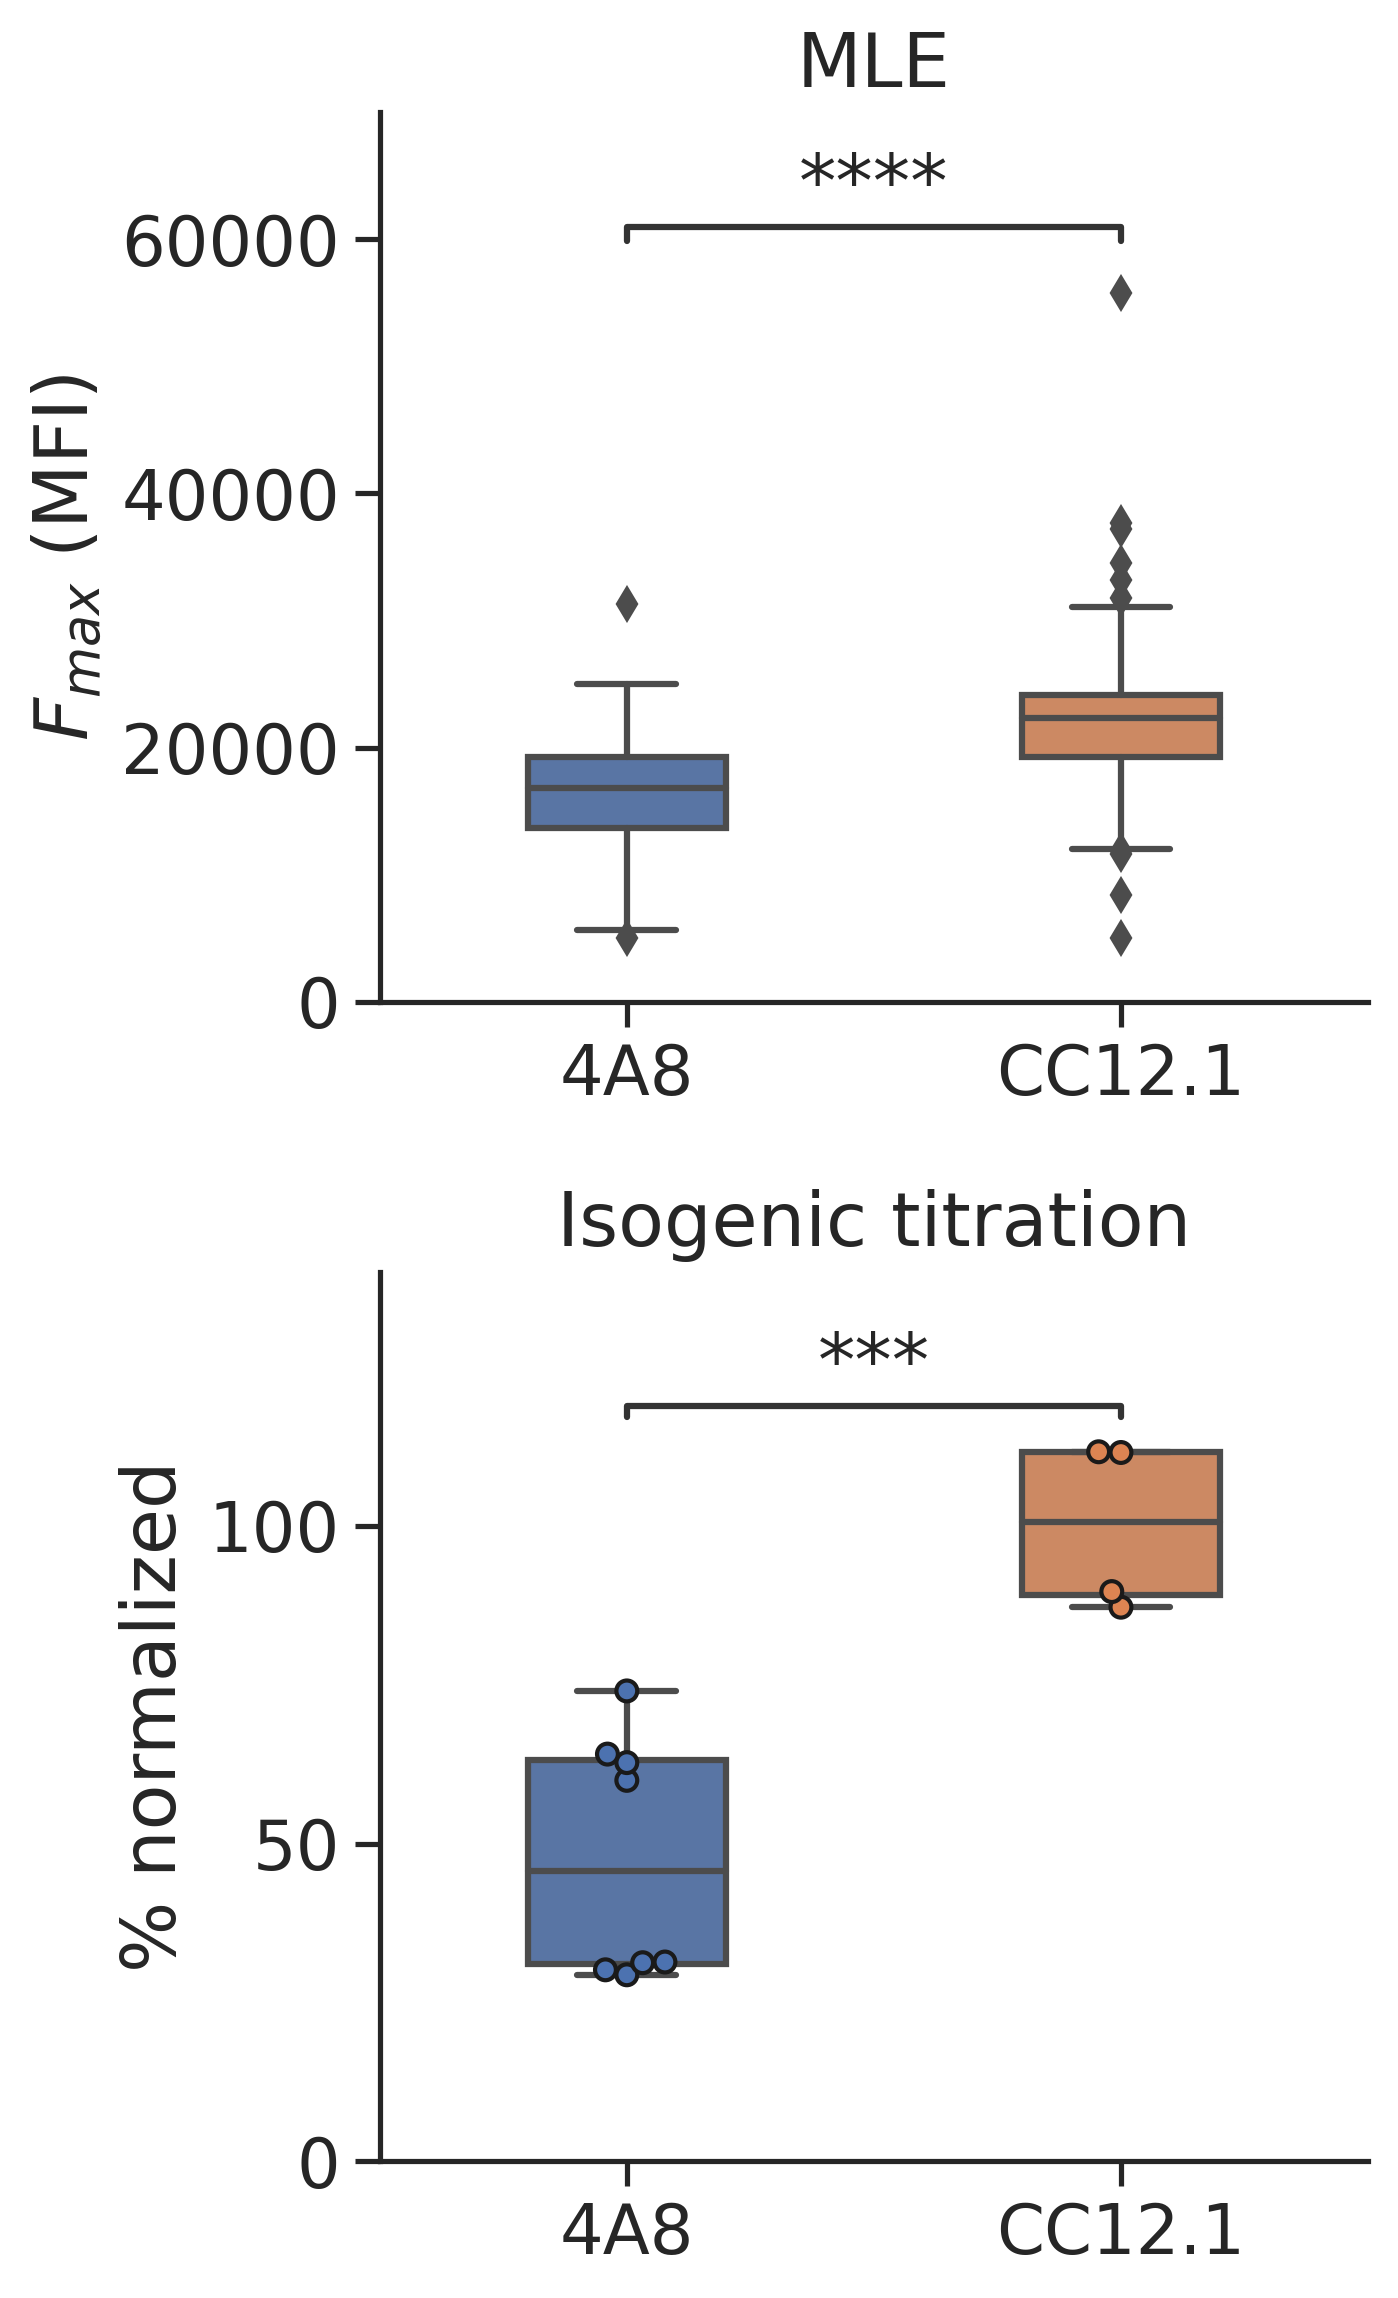

<Figure size 1500x2400 with 0 Axes>

In [31]:
def get_gene(input_str):
    gene = input_str.split(">")[0]
    return gene

colors = ["#01B0F0", "#FF8AD8"]
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "figure.figsize": (5, 8),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)
#sns.set_palette(sns.color_palette(colors))

df_col = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/output/Final/combine_top25-50_test1.csv")

df_col["Ab"] = df_col["Variant"].apply(get_gene)
print(df_col['Ab'].value_counts())
width=0.4
ax1 = plt.subplot(2, 1, 1)
ax1 = sns.boxplot(data=df_col, x='Ab', y='Fmax', width=width)
pairs=[("4A8", "CC121")]
annotator = Annotator(ax1, pairs, data=df_col, x='Ab', y='Fmax')
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()
ax1.set_title(r"MLE")
ax1.set_ylabel(r"$F_{max}$ (MFI)")
ax1.set_xlabel("")
ax1.set_xticks([0, 1], ['4A8', 'CC12.1'])
ax1.set_ylim((0, 70000))

df_titration_fmax = pd.read_csv("/projects/brpe7306/fab-library-barcoding/MLE/titration_data/titration_fmax.csv")
df_titration_fmax['normalized_pct'] = df_titration_fmax['normalized_pct']*1.11638
ax2 = plt.subplot(2, 1, 2)
ax2 = sns.boxplot(data=df_titration_fmax, x='Ab', y='normalized_pct', width=width)
ax2 = sns.swarmplot(data=df_titration_fmax, x='Ab', y='normalized_pct', edgecolor='k', linewidth=1)
pairs=[("4A8", "CC121")]
annotator = Annotator(ax2, pairs, data=df_titration_fmax, x='Ab', y='normalized_pct')
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()
ax2.set_ylabel(r"% normalized")
ax2.set_xlabel("")
ax2.set_ylim((0,140))
ax2.set_title(r"Isogenic titration")
ax2.set_xticks([0, 1], ['4A8', 'CC12.1'])
ax2.set_yticks([0,50,100], [0, 50, 100])
plt.tight_layout()
plt.savefig("/projects/brpe7306/fab-library-barcoding/MLE/output/fmax.png")
plt.show()
plt.clf()